## Introduction
This notebook tries to take in a sample dataset in notebook environment and run some tests to demo the verification of differential privacy algorithms. 

### Load the DP Verification Modules

In [1]:
import pandas as pd
import dp_verification as dp
import aggregation as agg
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
dv = dp.DPVerification(dataset_size=10000)
ag = agg.Aggregation(t=1, repeat_count=10000)

Loaded 10000 records


### Test Parameters

In [3]:
# Using the auto method of np.histogram to decide bin size
# Maximum of the ‘sturges’ and ‘fd’ estimators. Provides good all around performance.
numbins = 0

## Exact Counts

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10000.0  Stdev fD1:  0.0  Mean fD2:  9999.0  Stdev fD2:  0.0

KS 2-sample Test Result:  Ks_2sampResult(statistic=1.0, pvalue=0.0) 

Wasserstein Distance:  0.0 

DP Predicate Test: False 



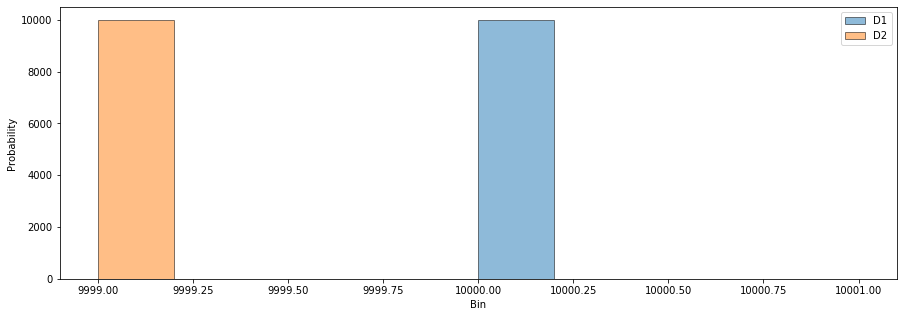

In [4]:
dp_exact, ks_exact, ws_exact = dv.aggtest(ag.exact_count, 'UserId', binsize = "unity", bound = False, exact = True)

If we do exact count repeatedly on a set D1 of 10K records and set D1 of 9,999 records (neighboring datasets), we shall get two histograms that are easily distinguishable from each other. So we can make out the extra record is in D1 vs D2. This is a trivial case of re-identification as it leads us to infer net new information about an individual record being part of D1 vs D2. 

#### Exact count fails the DP test

## Buggy Implementation of DP

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10005.00640527369  Stdev fD1:  2.872289302860187  Mean fD2:  10003.992950500719  Stdev fD2:  2.887608362720967

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.1074, pvalue=1.2941082951613566e-50) 

Wasserstein Distance:  2.9655172413793096 

DP Predicate Test: False 



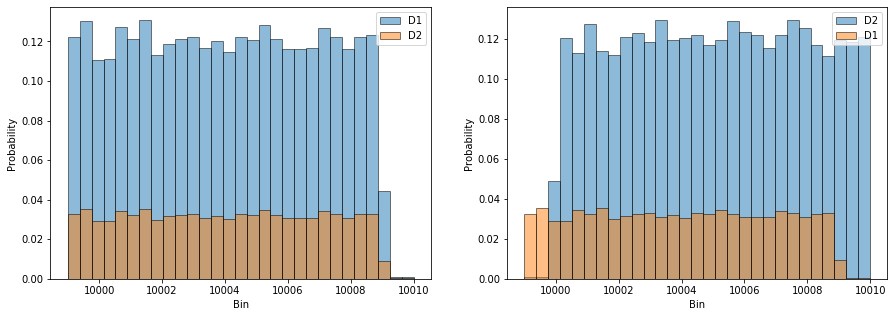

In [5]:
dp_buggy, ks_buggy, ws_buggy = dv.aggtest(ag.buggy_count, 'UserId', binsize="auto", debug=False,bound = True)

#### We can see that the histograms are not bounded. The test is able to uncover this implementation of DP noisy count is incorrect which is what we'd expect this test to uncover. 

## [DP Implementation as per MSR equations](https://www.yammer.com/microsoft.com/#/files/182490914816)

### COUNT Test

Length of D1:  10000  Length of D2:  9999
Mean fD1:  9999.95480932162  Stdev fD1:  5.301563575745068  Mean fD2:  9998.998384731454  Stdev fD2:  5.3200400066447

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0784, pvalue=3.808765148627586e-27) 

Wasserstein Distance:  5.45679012345679 

DP Predicate Test: True 



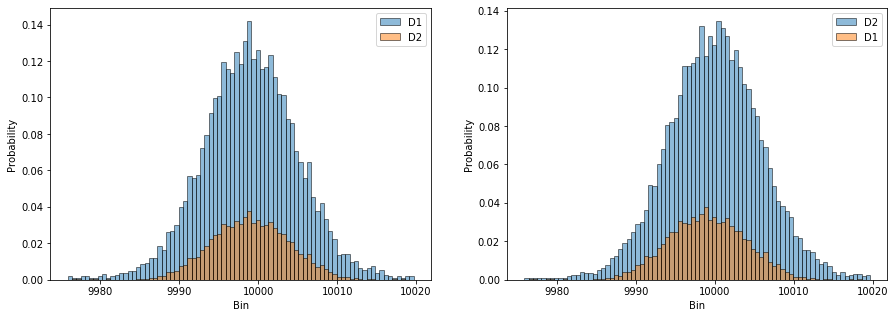

In [6]:
dp_count, ks_count, ws_count = dv.aggtest(ag.dp_count, 'UserId', binsize="auto", debug = False)

#### Noisy COUNT aggregation passes the DP Predicate test

### SUM Test

Length of D1:  10000  Length of D2:  9999
Mean fD1:  20013.054263432346  Stdev fD1:  64.51719634087591  Mean fD2:  20009.962483381896  Stdev fD2:  63.84899576819309

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0275, pvalue=0.0010385517933069264) 

Wasserstein Distance:  4.070588235294117 

DP Predicate Test: True 



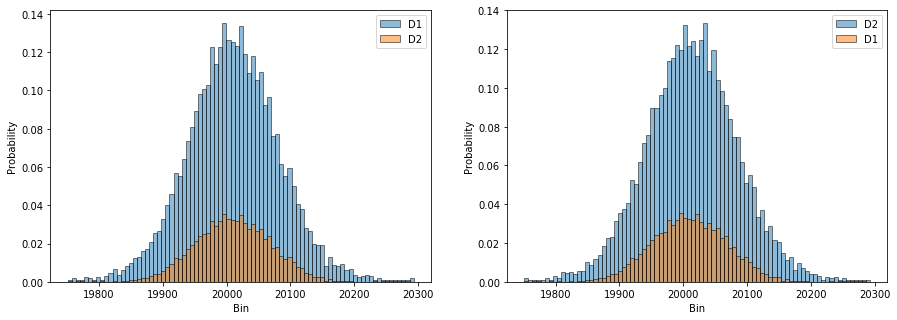

In [7]:
dp_sum, ks_sum, ws_sum = dv.aggtest(ag.dp_sum, 'Usage', binsize="auto")

#### Noisy SUM aggregation passes the DP predicate test

### Mean Test

Length of D1:  10000  Length of D2:  9999
Mean fD1:  2.001271207718558  Stdev fD1:  0.0064890539614701785  Mean fD2:  2.001484926140308  Stdev fD2:  0.006470230589010468

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0165, pvalue=0.13138496726749369) 

Wasserstein Distance:  5.037974683544304 

DP Predicate Test: True 



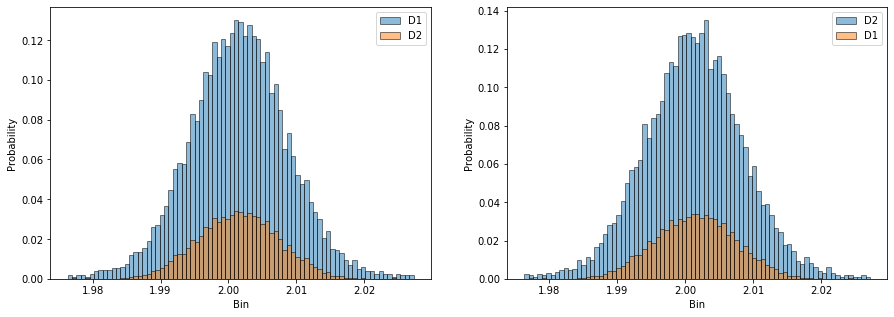

In [8]:
dp_mean, ks_mean, ws_mean = dv.aggtest(ag.dp_mean, 'Usage', binsize="auto", debug=False, plot=True)

#### Noisy mean passes the DP Predicate test

### Variance Test

Length of D1:  10000  Length of D2:  9999
Mean fD1:  2.0518948383786015  Stdev fD1:  0.09250734414565505  Mean fD2:  2.051949471009194  Stdev fD2:  0.09405594151391301

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0137, pvalue=0.30504141099080584) 

Wasserstein Distance:  6.5352112676056375 

DP Predicate Test: True 



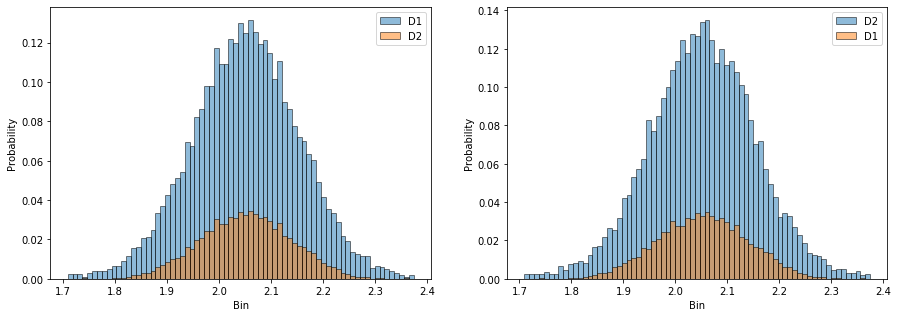

In [9]:
dp_var, ks_var, ws_var = dv.aggtest(ag.dp_var, 'Usage', binsize="auto", debug=False)

#### Noisy variance passes the DP Predicate test

### Comparing fD1 and fD2 without bounding

Length of D1:  10000  Length of D2:  9999
Mean fD1:  9999.980325412766  Stdev fD1:  5.371379137621207  Mean fD2:  9999.031378543827  Stdev fD2:  5.288191355084051

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0794, pvalue=7.835640605114273e-28) 

Wasserstein Distance:  4.951219512195123 

DP Predicate Test: True 



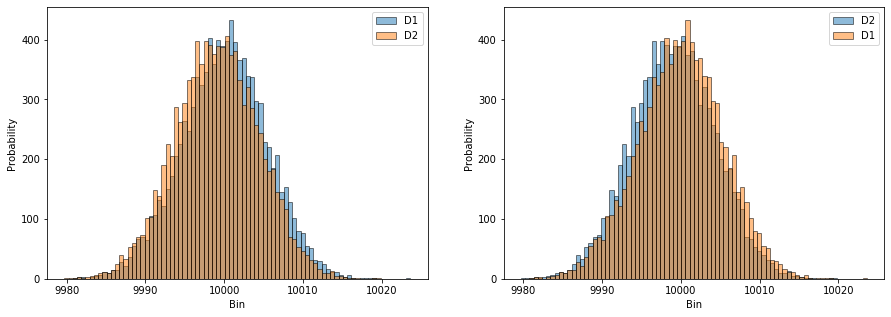

(True,
 Ks_2sampResult(statistic=0.0794, pvalue=7.835640605114273e-28),
 4.951219512195123)

In [10]:
dv.aggtest(ag.dp_count, 'UserId', binsize="auto", debug = False, bound=False)

### Plotting KS Test Results by different aggregate functions

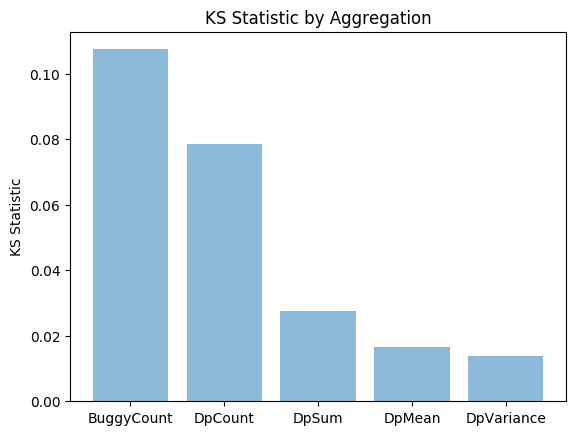

In [11]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('BuggyCount', 'DpCount', 'DpSum', 'DpMean', 'DpVariance')
y_pos = np.arange(len(objects))

ks_stat = [ks_buggy[0],
          ks_count[0],
          ks_sum[0],
          ks_mean[0],
          ks_var[0]]

plt.bar(y_pos, ks_stat, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('KS Statistic')
plt.title('KS Statistic by Aggregation')

plt.show()

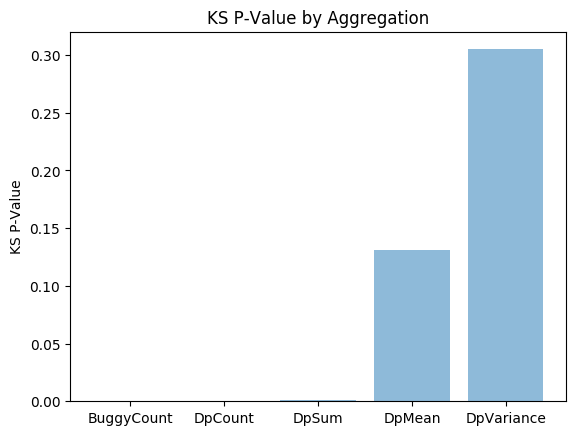

In [12]:
ks_stat = [ks_buggy[1],
          ks_count[1],
          ks_sum[1],
          ks_mean[1],
          ks_var[1]]

plt.bar(y_pos, ks_stat, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('KS P-Value')
plt.title('KS P-Value by Aggregation')

plt.show()

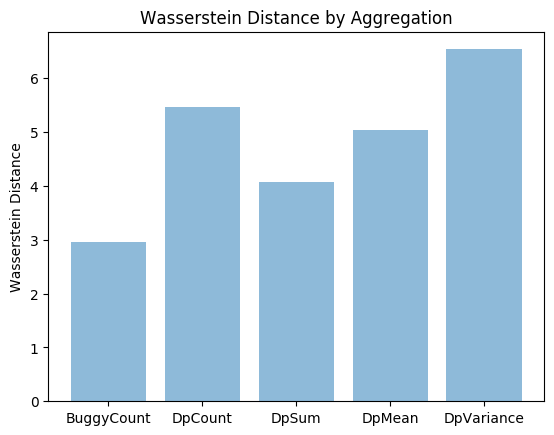

In [13]:
ws_stat = [ws_buggy,
          ws_count,
          ws_sum,
          ws_mean,
          ws_var]

plt.bar(y_pos, ws_stat, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Wasserstein Distance')
plt.title('Wasserstein Distance by Aggregation')

plt.show()

### Time to run the DP Tests

In [14]:
import time
start_time = time.time()
dp_count, ks_count, ws_count = dv.aggtest(ag.dp_count, 'UserId', binsize="auto", debug=False, plot=False)
print("--- %s seconds ---" % (time.time() - start_time))

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10000.003150446026  Stdev fD1:  5.329548568121991  Mean fD2:  9999.068096604222  Stdev fD2:  5.345181279124184

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0682, pvalue=1.21976233733592e-20) 

Wasserstein Distance:  4.409638554216866 

DP Predicate Test: True 

--- 0.04225778579711914 seconds ---


In [15]:
start_time = time.time()
dp_sum, ks_sum, ws_sum = dv.aggtest(ag.dp_sum, 'Usage', binsize="auto", debug=False, plot=False)
print("--- %s seconds ---" % (time.time() - start_time))

Length of D1:  10000  Length of D2:  9999
Mean fD1:  20012.521400350048  Stdev fD1:  64.33678728785993  Mean fD2:  20009.570909004782  Stdev fD2:  63.991294298451635

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0212, pvalue=0.022340230544746754) 

Wasserstein Distance:  5.788235294117644 

DP Predicate Test: True 

--- 0.1525721549987793 seconds ---


In [16]:
start_time = time.time()
dp_count, ks_count, ws_count = dv.aggtest(ag.buggy_count, 'UserId', binsize="auto", debug=False, plot=False)
print("--- %s seconds ---" % (time.time() - start_time))

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10004.954461149271  Stdev fD1:  2.8988207643457353  Mean fD2:  10003.953225665098  Stdev fD2:  2.892072355511362

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.1069, pvalue=3.793908925840325e-50) 

Wasserstein Distance:  4.689655172413794 

DP Predicate Test: False 

--- 0.0958395004272461 seconds ---


### Verifying Whitenoie-System Private Query Mechanism implementation

#### Laplace mechanism - COUNT

Length of D1:  10000  Length of D2:  9999
Mean fD1:  9999.990625044435  Stdev fD1:  1.4315833125626183  Mean fD2:  9999.001135662145  Stdev fD2:  1.4341290552702846

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.3887, pvalue=0.0) 

Wasserstein Distance:  3.108108108108109 

DP Predicate Test: True 



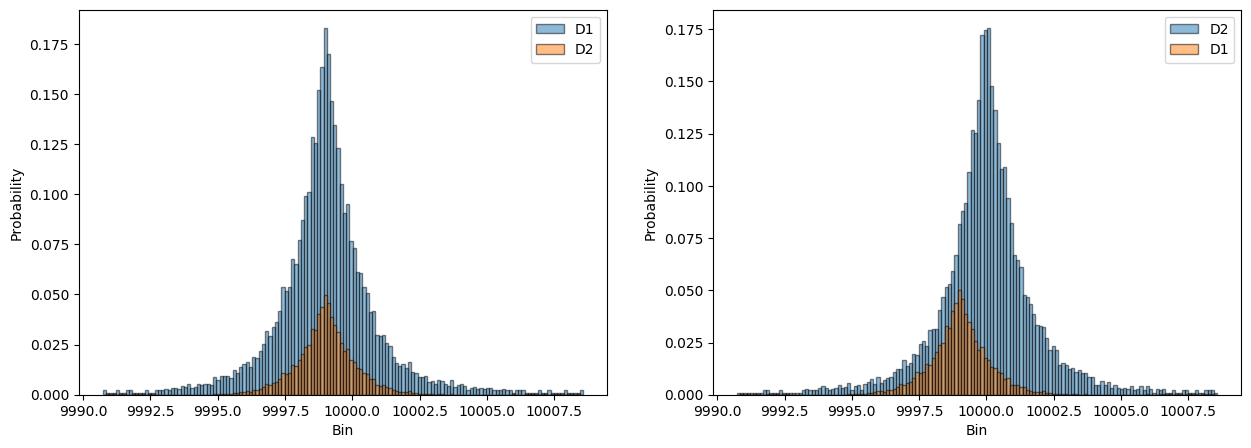

In [17]:
dp_count, ks_count, ws_count = dv.aggtest(ag.dp_mechanism_count, 'UserId', binsize="auto", debug = False)

#### Laplace mechanism - SUM

Length of D1:  10000  Length of D2:  9999
Mean fD1:  20012.929248937915  Stdev fD1:  17.21660809143227  Mean fD2:  20009.807827955367  Stdev fD2:  16.956368931459878

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.1242, pvalue=1.3752969691032261e-67) 

Wasserstein Distance:  2.5824175824175803 

DP Predicate Test: True 



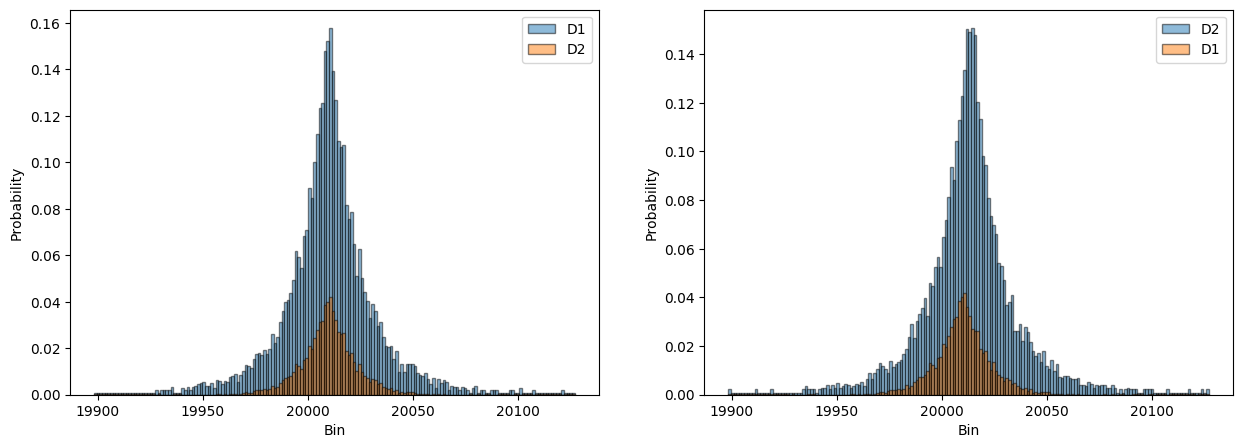

In [18]:
dp_sum, ks_sum, ws_sum = dv.aggtest(ag.dp_mechanism_sum, 'Usage', binsize="auto", debug=False)

#### Gaussian mechanism - Count

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10000.020153618389  Stdev fD1:  8.637609900399976  Mean fD2:  9998.901039907303  Stdev fD2:  8.657019648731703

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0564, pvalue=3.017551594928787e-14) 

Wasserstein Distance:  5.458823529411765 

DP Predicate Test: True 



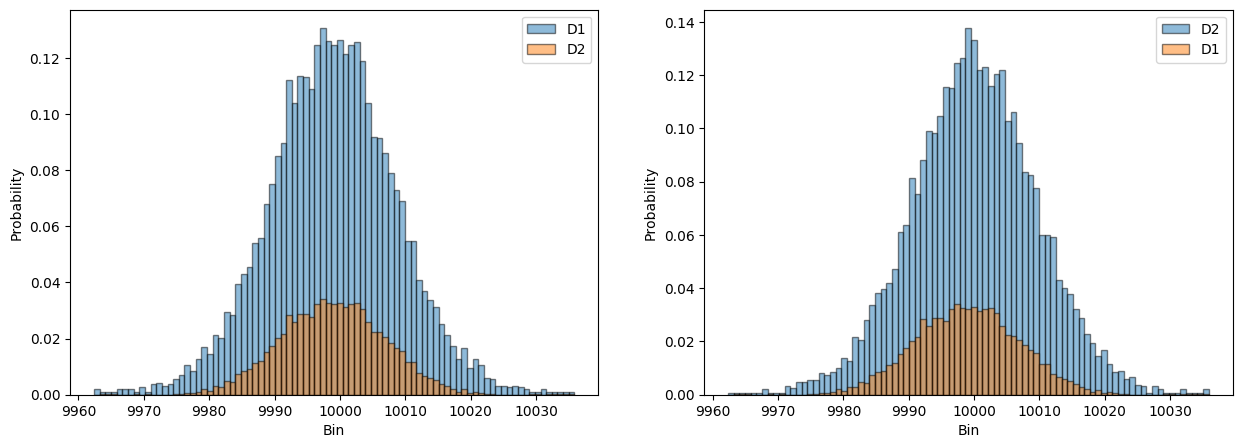

In [19]:
ag = agg.Aggregation(t=1, repeat_count=10000, mechanism = "Gaussian")
dp_count, ks_count, ws_count = dv.aggtest(ag.dp_mechanism_count, 'UserId', binsize="auto", debug = False)

#### Gaussian Mechanism - SUM

Length of D1:  10000  Length of D2:  9999
Mean fD1:  20013.02356524026  Stdev fD1:  8.614725885800343  Mean fD2:  20011.897702085356  Stdev fD2:  8.684310053740225

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0565, pvalue=2.6950891481067712e-14) 

Wasserstein Distance:  4.7380952380952355 

DP Predicate Test: True 



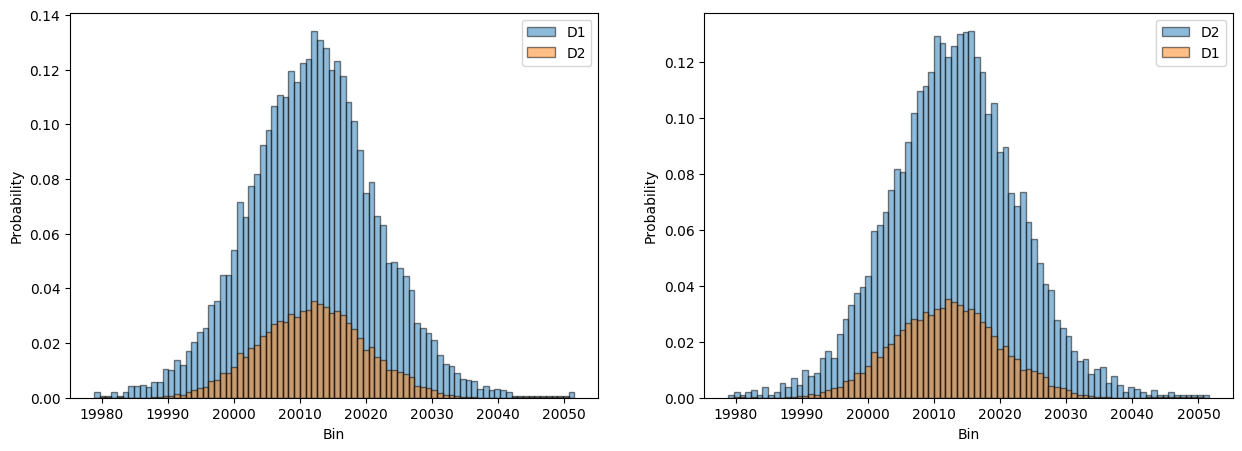

In [20]:
dp_sum, ks_sum, ws_sum = dv.aggtest(ag.dp_mechanism_sum, 'Usage', binsize="auto", debug=False)

### Verifying Whitenoise-System Private Query implementation for a sample query

#### Note: Whitenoise-System uses Laplace noise by default right now but has support for both Laplace and Gaussian noise

### SUM DP Predicate Test

Length of D1:  10000  Length of D2:  9999
Mean signed deviation ratio to actual:  0.00021675910658072254
p-Value of 1 sample t-test:  0.5086434773392864


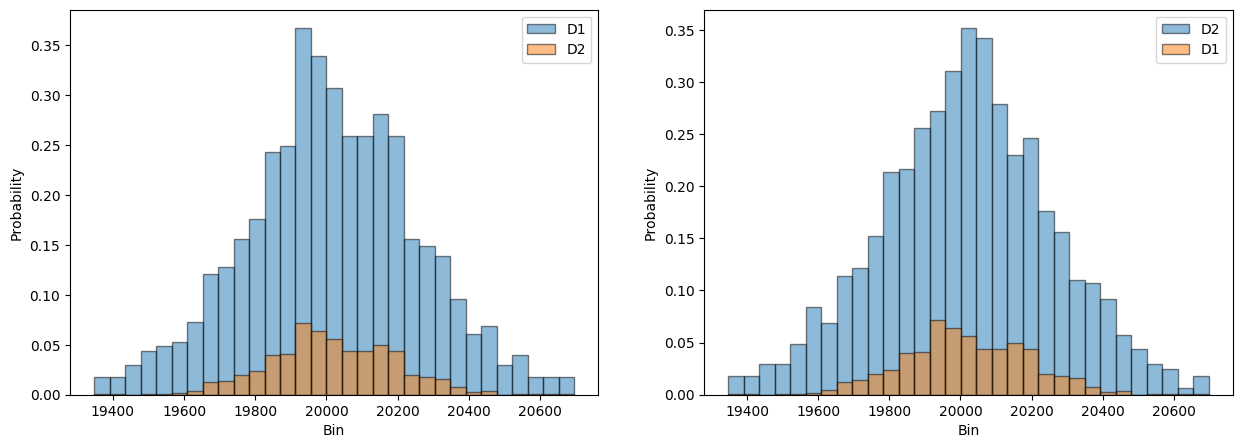

DP Predicate Test:  True
Bias Test:  True
--- 34.5198187828064 seconds ---


In [21]:
ag = agg.Aggregation(t=1, repeat_count=10000, mechanism = "Laplace")
start_time = time.time()
# Applying same query on neighboring datasets
d1_query = "SELECT SUM(Usage) AS TotalUsage FROM d1.d1"
d2_query = "SELECT SUM(Usage) AS TotalUsage FROM d2.d2"
dp_res, acc_res, utility_res, bias_res = dv.dp_query_test(d1_query, d2_query, plot=True, repeat_count=1000)
print("DP Predicate Test: ", dp_res)
#print("Accuracy Test: ", acc_res)
#print("Utility Test: ", utility_res)
print("Bias Test: ", bias_res)
print("--- %s seconds ---" % (time.time() - start_time))

### COUNT DP Predicate Test

Length of D1:  10000  Length of D2:  9999
Mean signed deviation ratio to actual:  -6.25e-05
p-Value of 1 sample t-test:  0.01418706582887354


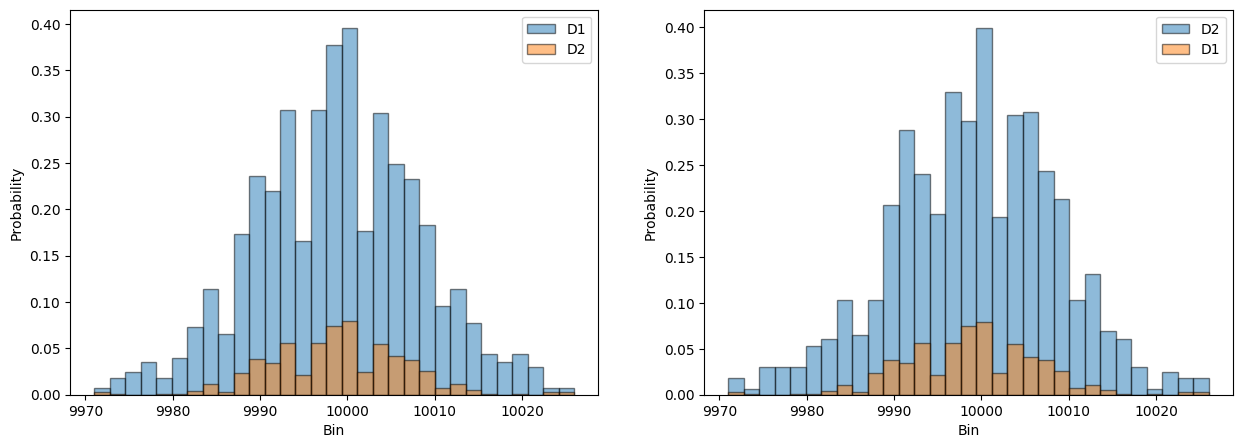

DP Predicate Test:  True
Bias Test:  False
--- 19.981481790542603 seconds ---


In [22]:
start_time = time.time()
# Applying same query on neighboring datasets
d1_query = "SELECT COUNT(UserId) AS TotalUserCount FROM d1.d1"
d2_query = "SELECT COUNT(UserId) AS TotalUserCount FROM d2.d2"
dp_res, acc_res, utility_res, bias_res = dv.dp_query_test(d1_query, d2_query, plot=True, repeat_count=1000)
print("DP Predicate Test: ", dp_res)
#print("Accuracy Test: ", acc_res)
#print("Utility Test: ", utility_res)
print("Bias Test: ", bias_res)
print("--- %s seconds ---" % (time.time() - start_time))

### MEAN DP Predicate Test

Length of D1:  10000  Length of D2:  9999
Mean signed deviation ratio to actual:  0.0004473590224003722
p-Value of 1 sample t-test:  0.190290838302431


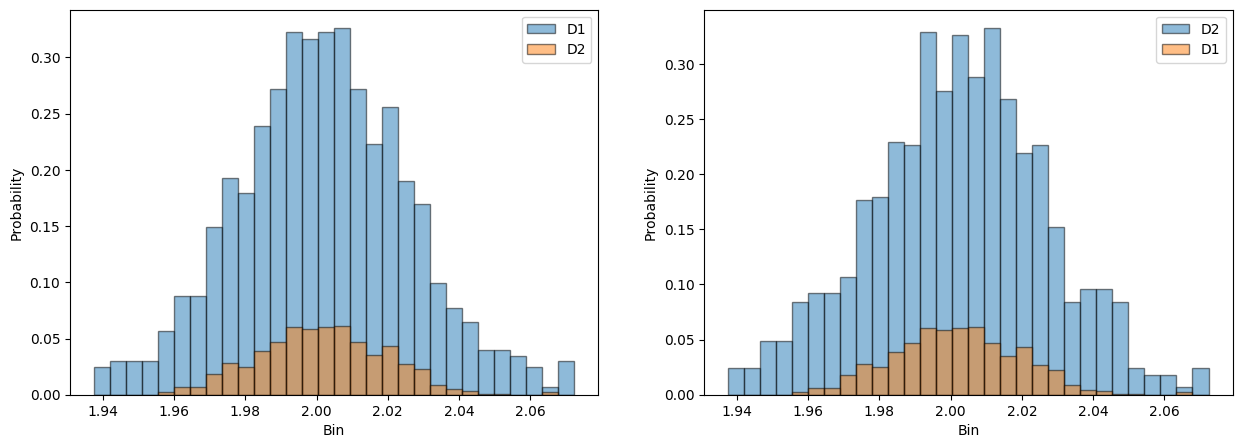

DP Predicate Test:  True
Bias Test:  True
--- 28.794368267059326 seconds ---


In [23]:
start_time = time.time()
# Applying same query on neighboring datasets
d1_query = "SELECT AVG(Usage) AS AvgUsage FROM d1.d1"
d2_query = "SELECT AVG(Usage) AS AvgUsage FROM d2.d2"
dp_res, acc_res, utility_res, bias_res = dv.dp_query_test(d1_query, d2_query, plot=True, repeat_count=1000)
print("DP Predicate Test: ", dp_res)
#print("Accuracy Test: ", acc_res)
#print("Utility Test: ", utility_res)
print("Bias Test: ", bias_res)
print("--- %s seconds ---" % (time.time() - start_time))

### Powerset Test

Test case:  [0.0, -333.33333333333337, -600.0]
Testing:  012_0
Mean signed deviation ratio to actual:  0.3248424467263661
p-Value of 1 sample t-test:  0.41035446392859387
DP Predicate Test Result:  True


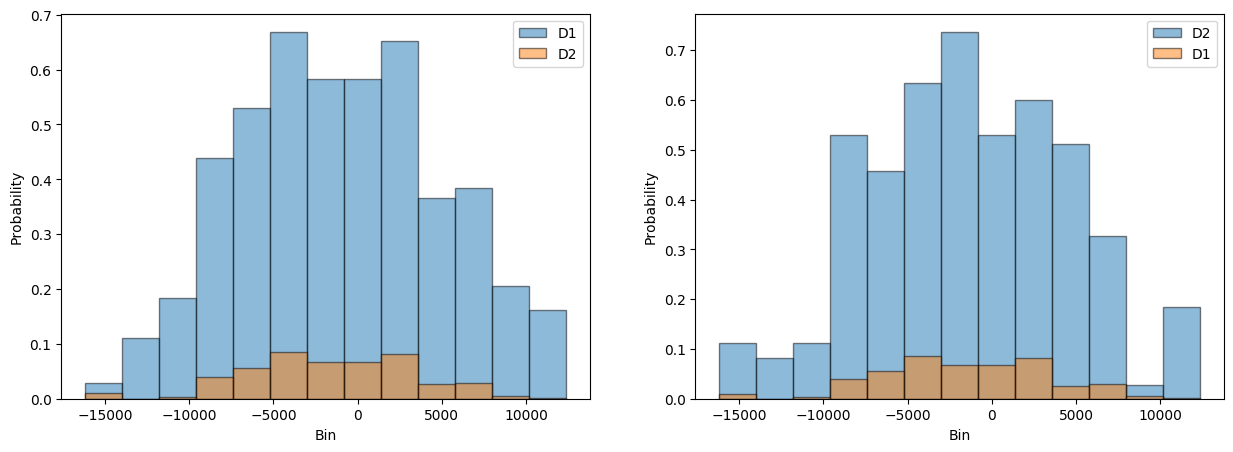

Testing:  12_1
Mean signed deviation ratio to actual:  -0.8270524612473353
p-Value of 1 sample t-test:  0.03908985291336486
DP Predicate Test Result:  True


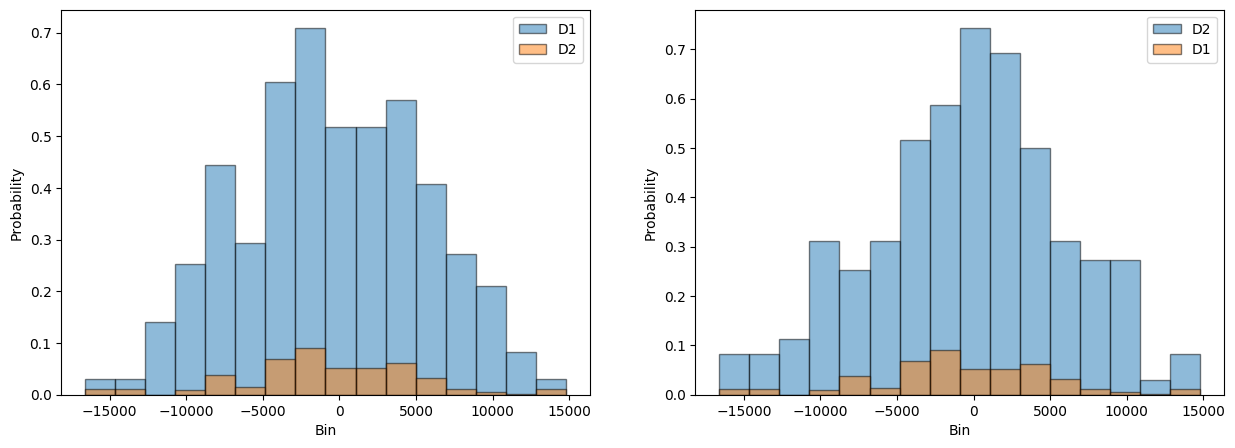

Testing:  2_2
Mean signed deviation ratio to actual:  -1.2862842175954239
p-Value of 1 sample t-test:  0.022903029670154278
DP Predicate Test Result:  True


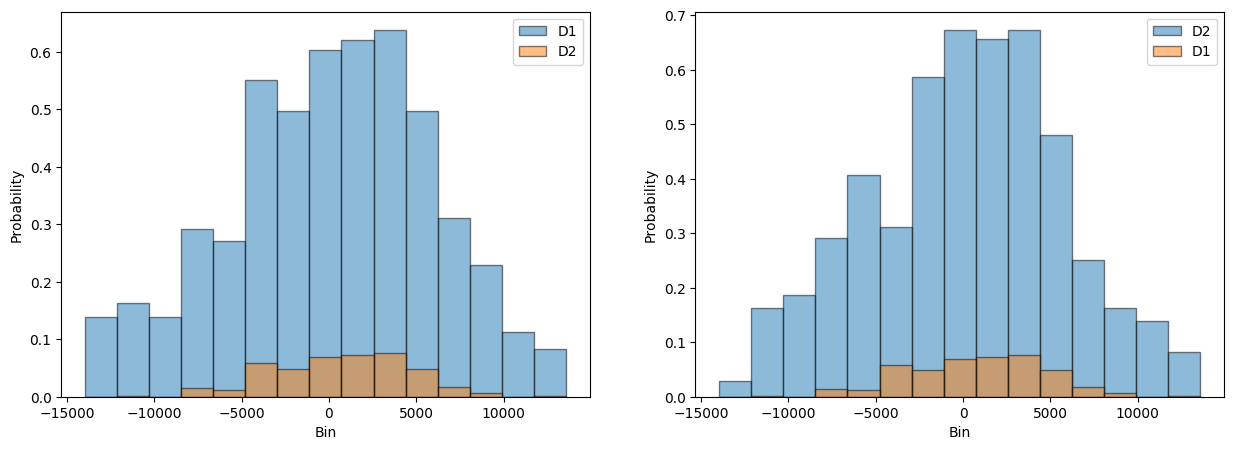

Testing:  12_2
Mean signed deviation ratio to actual:  -0.4440021023327993
p-Value of 1 sample t-test:  0.29634883190557304
DP Predicate Test Result:  True


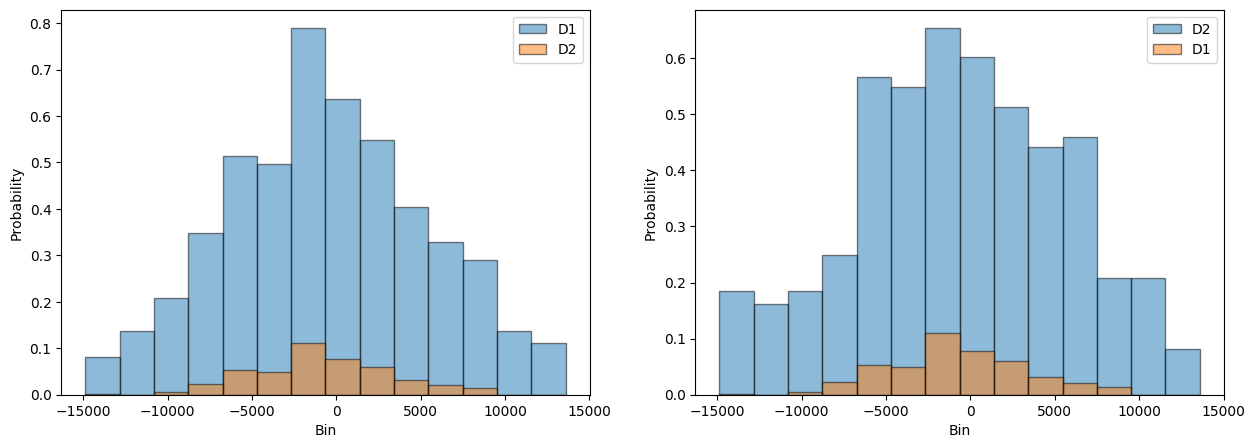

Testing:  1_1
Mean signed deviation ratio to actual:  -1.1421142694601338
p-Value of 1 sample t-test:  0.05575822226667898
DP Predicate Test Result:  True


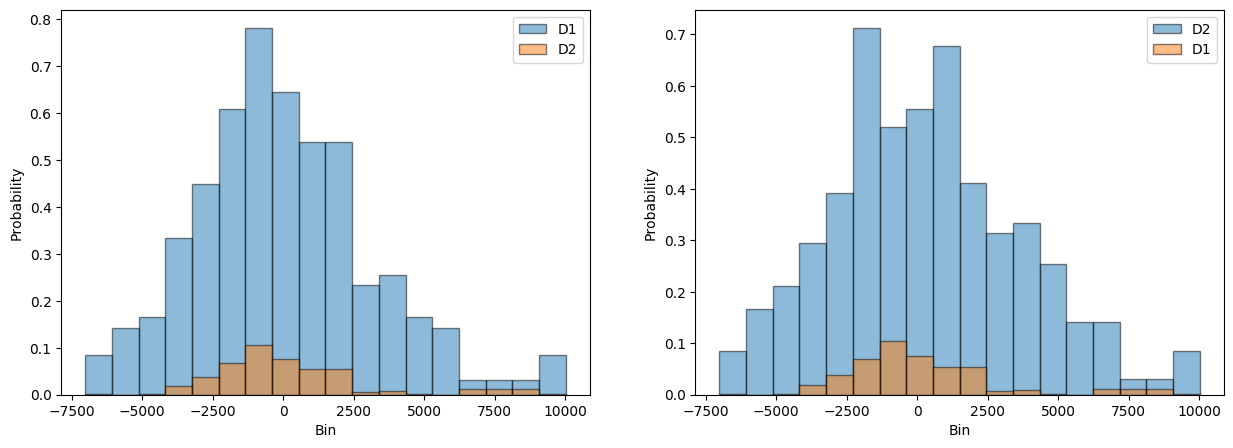

Testing:  012_1
Mean signed deviation ratio to actual:  -0.16220149940321107
p-Value of 1 sample t-test:  0.6886698729596112
DP Predicate Test Result:  True


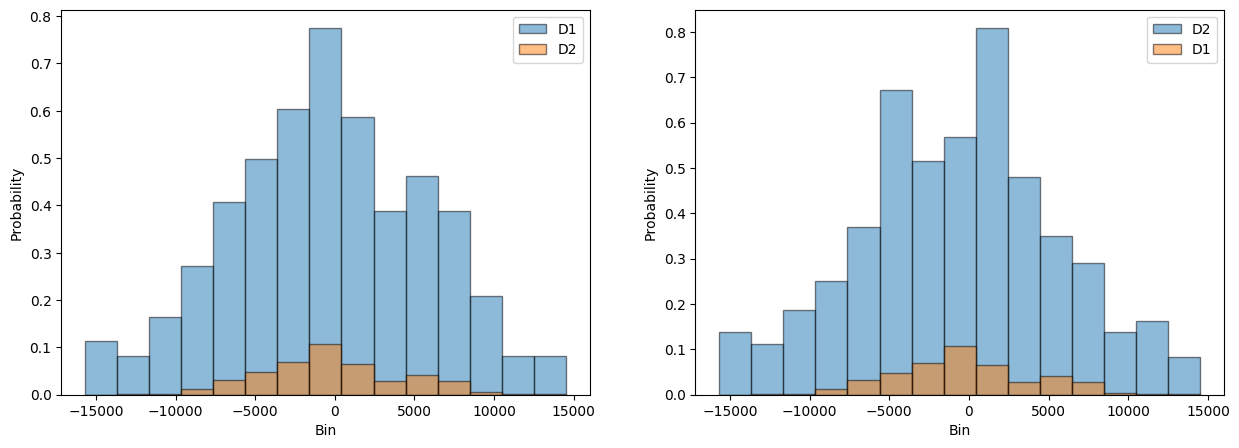

Testing:  02_0
Mean signed deviation ratio to actual:  0.21262762769616061
p-Value of 1 sample t-test:  0.6878630400029402
DP Predicate Test Result:  True


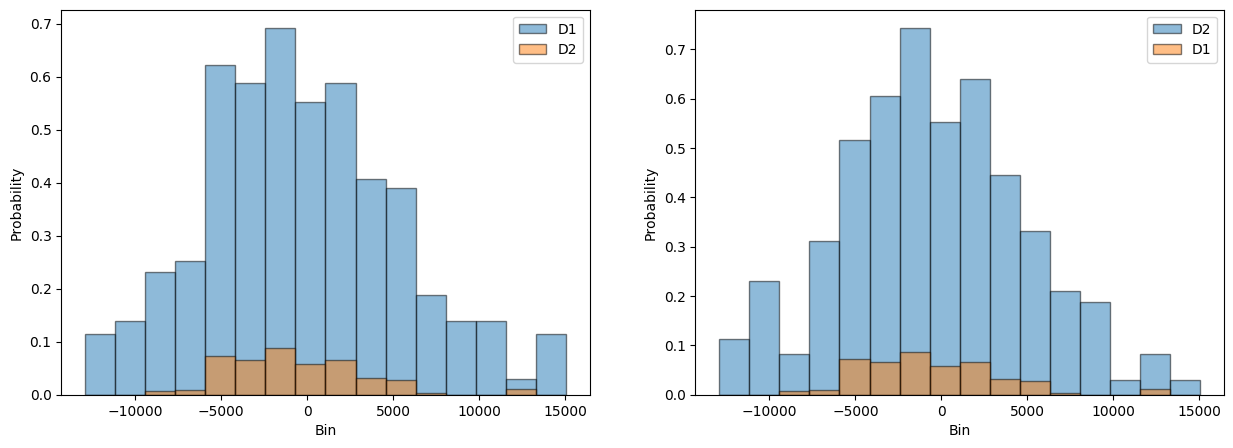

Testing:  02_2
Mean signed deviation ratio to actual:  -1.3469954654379932
p-Value of 1 sample t-test:  0.03489069414523594
DP Predicate Test Result:  True


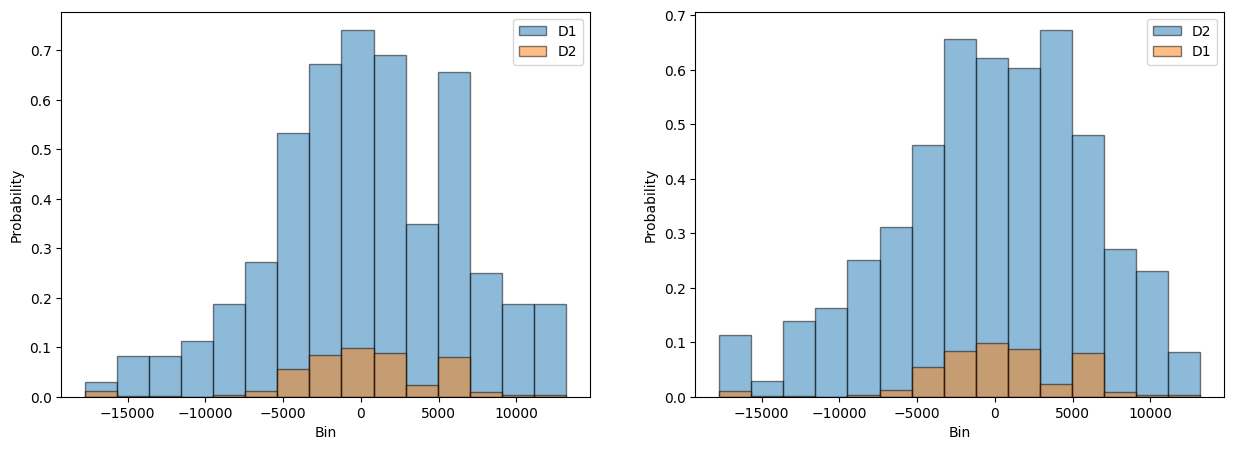

Testing:  0_0
Mean signed deviation ratio to actual:  nan
p-Value of 1 sample t-test:  nan
DP Predicate Test Result:  True


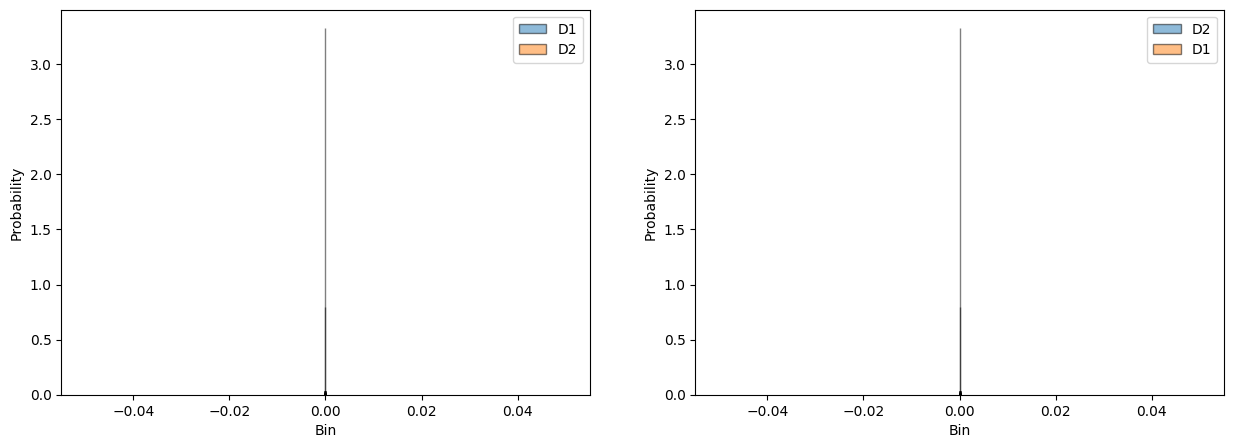

Testing:  012_2
Mean signed deviation ratio to actual:  0.29540355087739634
p-Value of 1 sample t-test:  0.4614054766191854
DP Predicate Test Result:  True


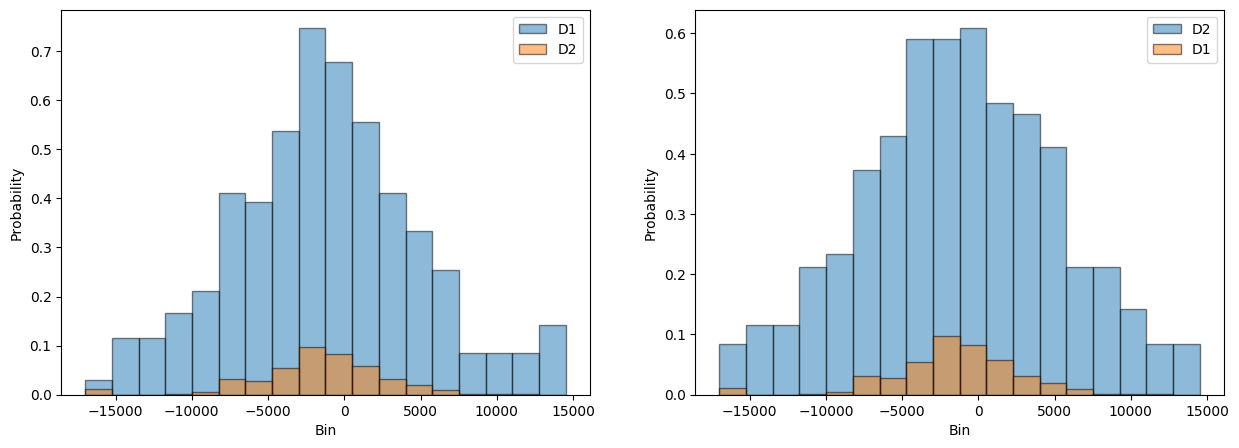

Testing:  01_0
Mean signed deviation ratio to actual:  -0.36587712069419087
p-Value of 1 sample t-test:  0.5273583590298387
DP Predicate Test Result:  True


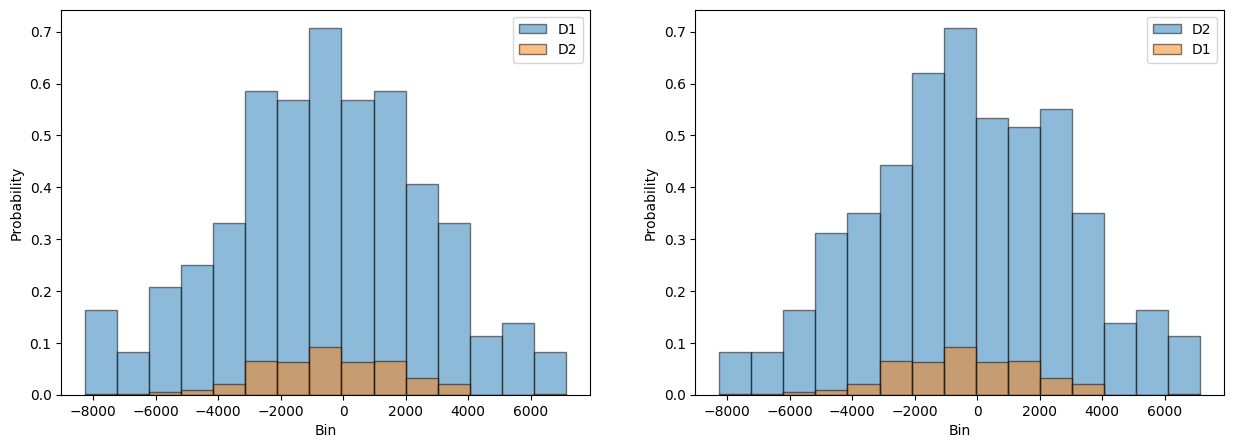

Testing:  01_1
Mean signed deviation ratio to actual:  -0.6329804227640828
p-Value of 1 sample t-test:  0.2711676139036943
DP Predicate Test Result:  True


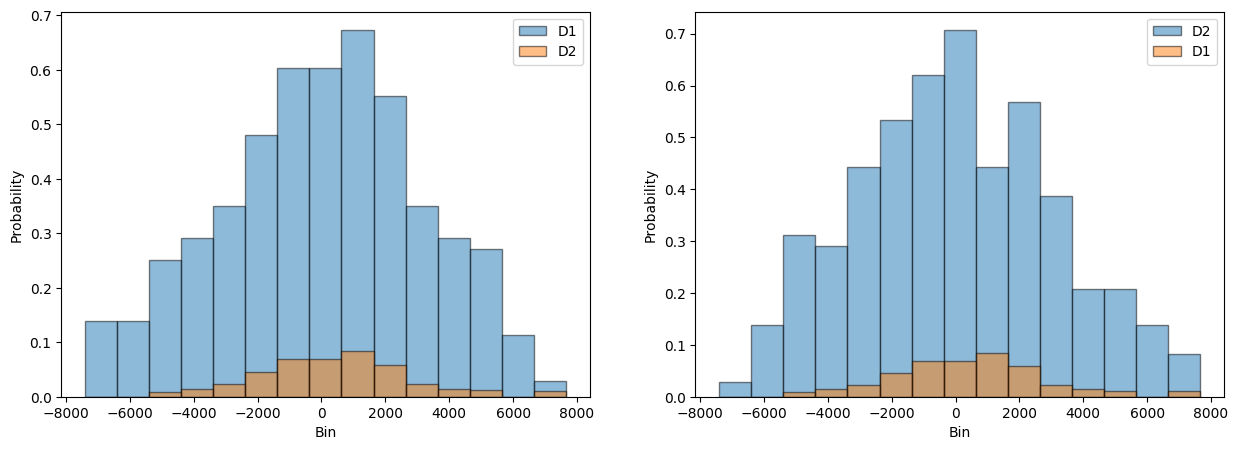

Test case:  [-500.0, 333.33333333333326, -200.0]
Testing:  012_0
Mean signed deviation ratio to actual:  0.121002441043941
p-Value of 1 sample t-test:  0.7458107426762625
DP Predicate Test Result:  True


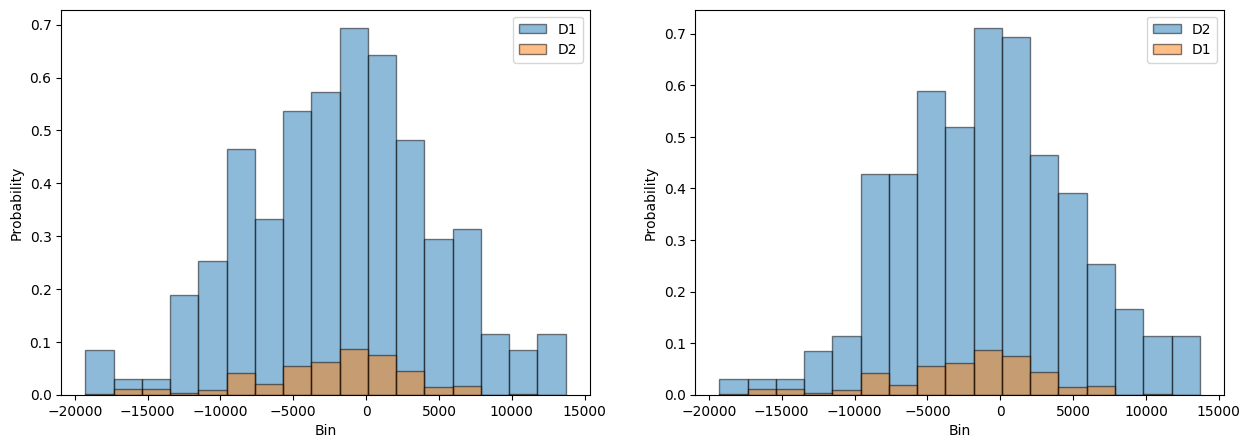

Testing:  12_1
Mean signed deviation ratio to actual:  -0.1108313527165463
p-Value of 1 sample t-test:  0.769279291251485
DP Predicate Test Result:  True


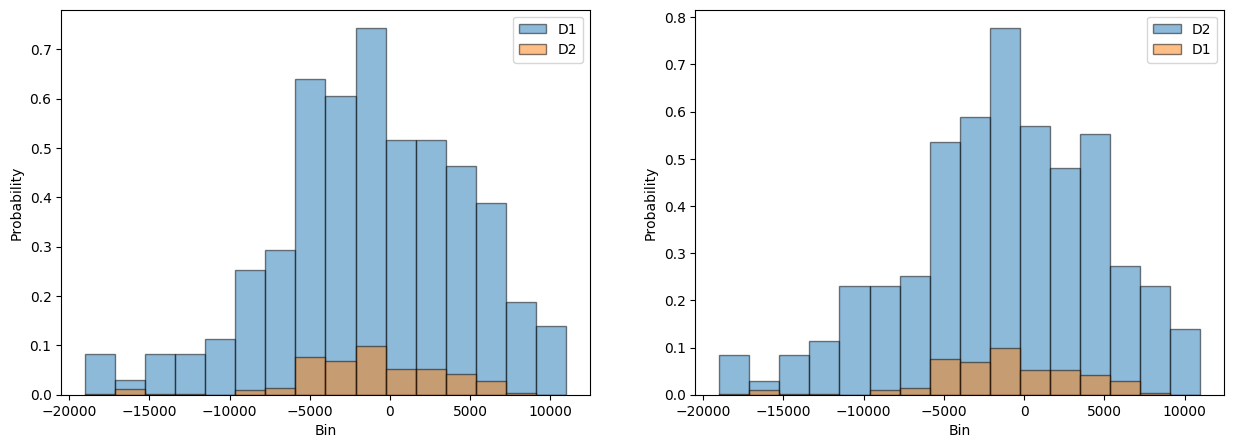

Testing:  2_2
Mean signed deviation ratio to actual:  -0.6240858083067351
p-Value of 1 sample t-test:  0.2803688105609009
DP Predicate Test Result:  True


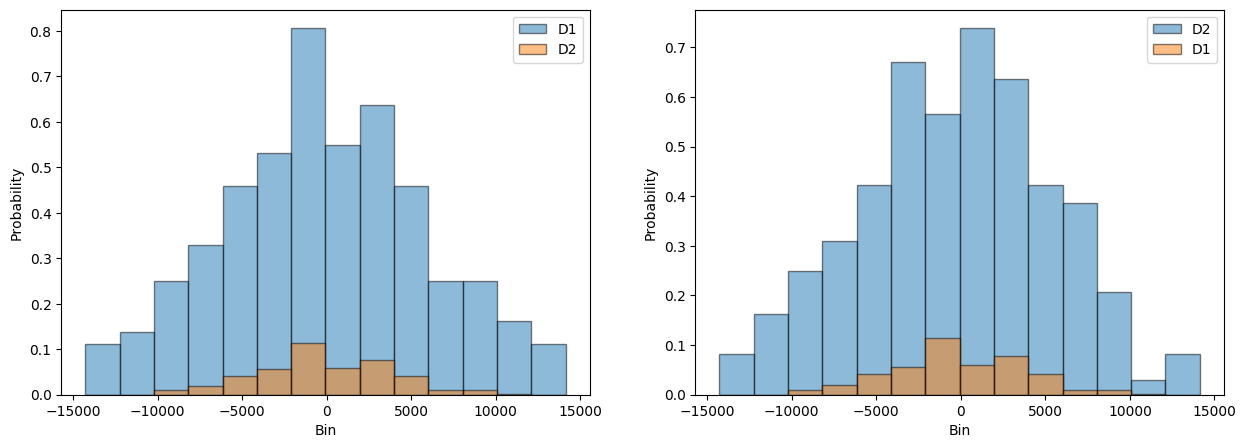

Testing:  12_2
Mean signed deviation ratio to actual:  0.06536548626484866
p-Value of 1 sample t-test:  0.8643899432718616
DP Predicate Test Result:  True


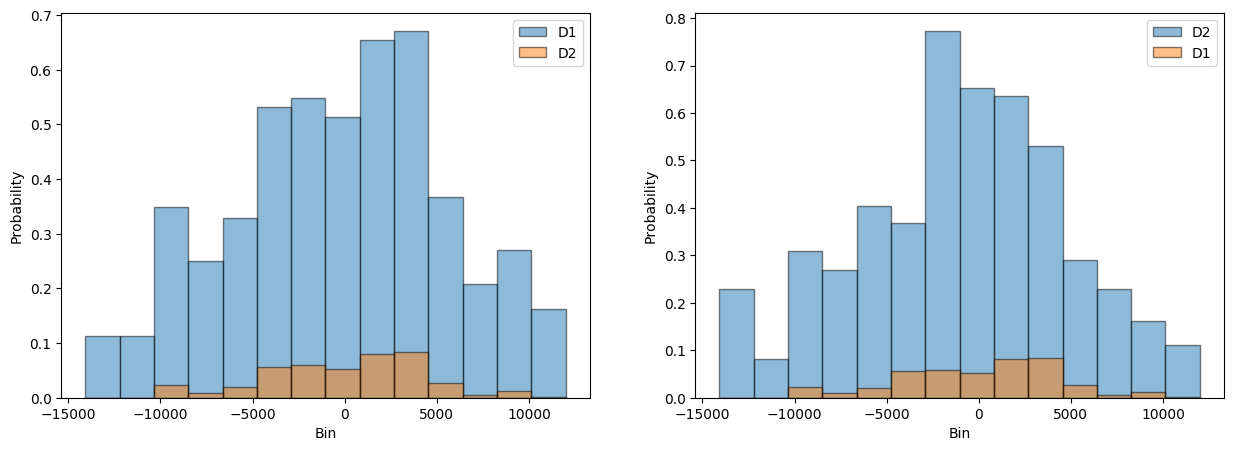

Testing:  1_1
Mean signed deviation ratio to actual:  -1.8558950233813623
p-Value of 1 sample t-test:  0.002411319433502892
DP Predicate Test Result:  True


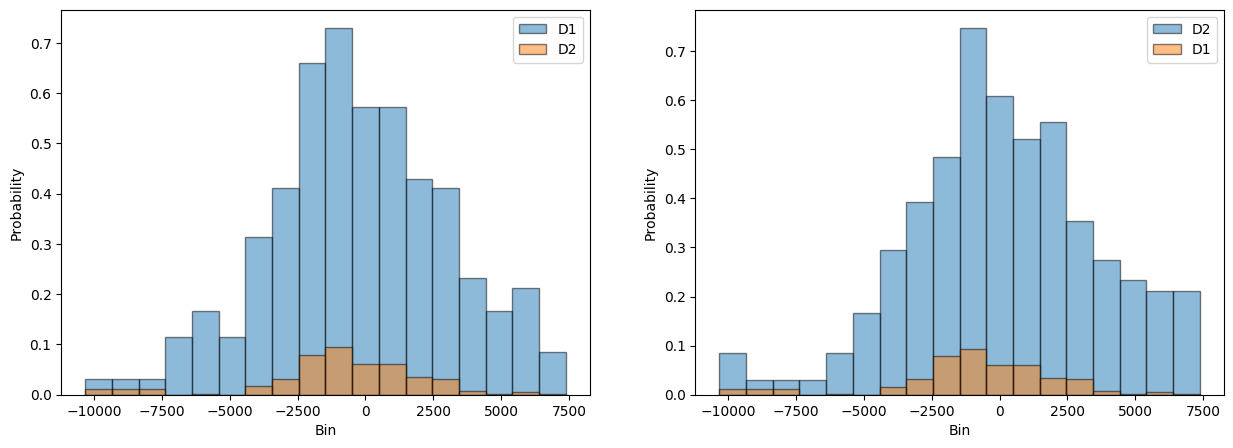

Testing:  012_1
Mean signed deviation ratio to actual:  -0.05910209660433413
p-Value of 1 sample t-test:  0.878448419810549
DP Predicate Test Result:  True


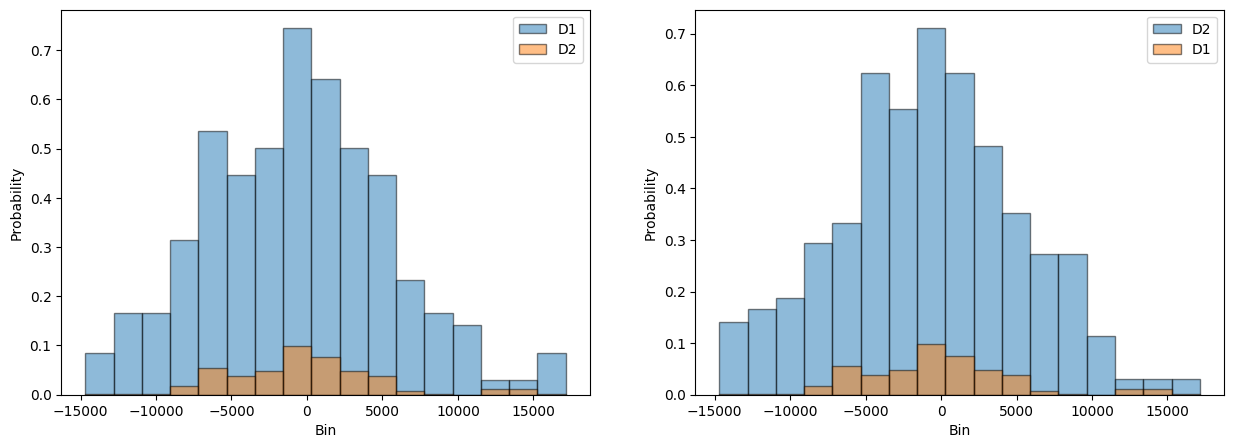

Testing:  02_0
Mean signed deviation ratio to actual:  1.238589109129428
p-Value of 1 sample t-test:  0.025284999831684384
DP Predicate Test Result:  True


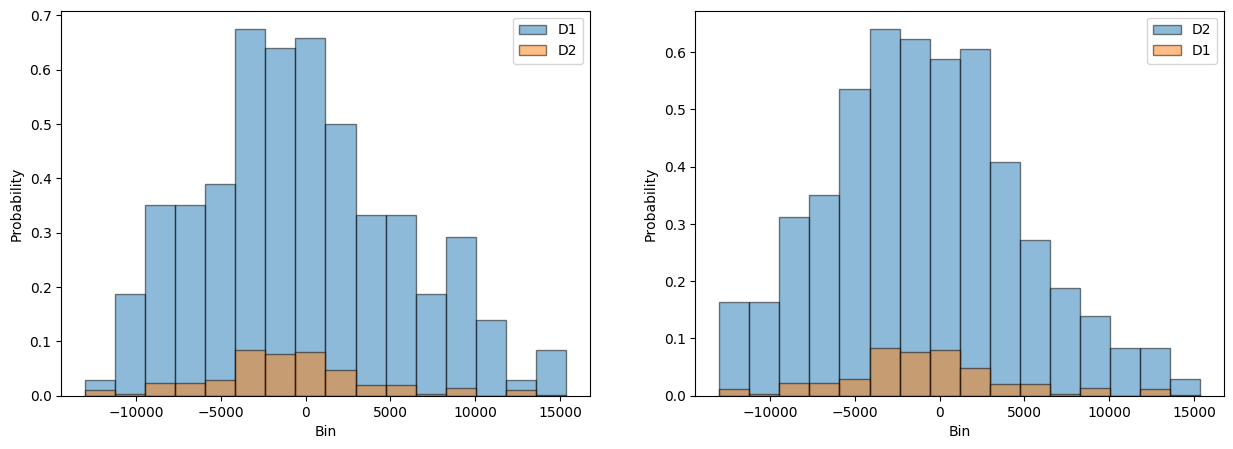

Testing:  02_2
Mean signed deviation ratio to actual:  0.43124186243550433
p-Value of 1 sample t-test:  0.4955676141161811
DP Predicate Test Result:  True


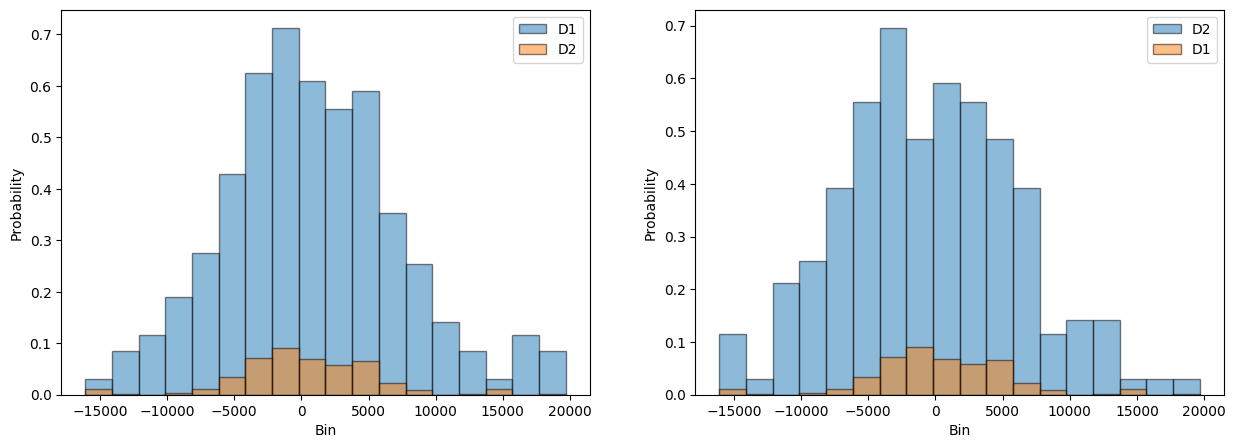

Testing:  0_0
Mean signed deviation ratio to actual:  nan
p-Value of 1 sample t-test:  nan
DP Predicate Test Result:  True


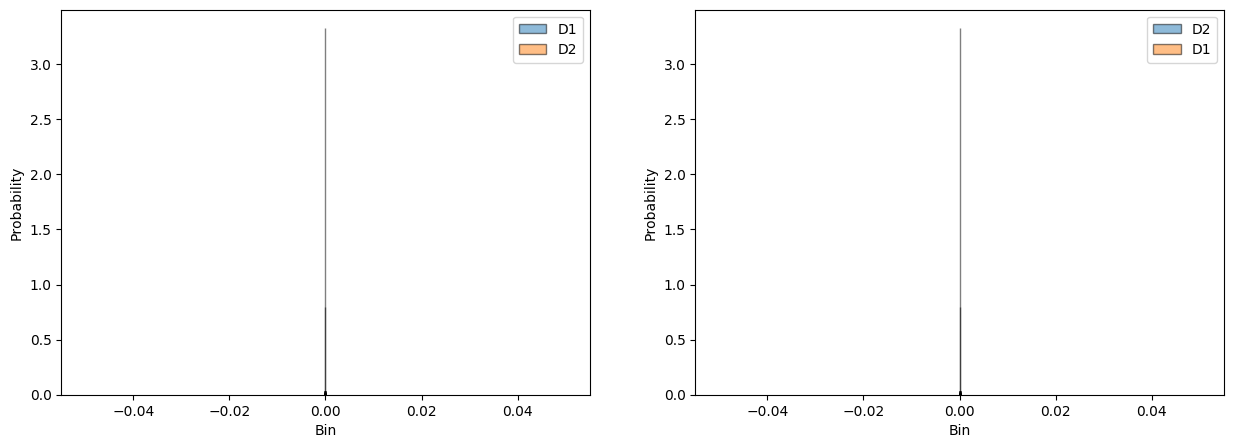

Testing:  012_2
Mean signed deviation ratio to actual:  -0.39463977935370614
p-Value of 1 sample t-test:  0.3065576633520544
DP Predicate Test Result:  True


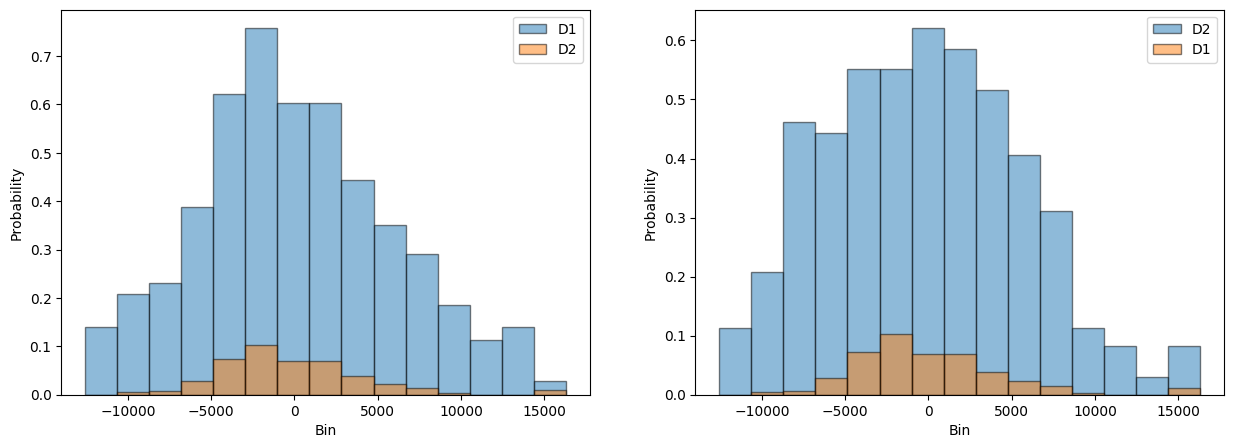

Testing:  01_0
Mean signed deviation ratio to actual:  -0.19461455282939827
p-Value of 1 sample t-test:  0.7578088469418045
DP Predicate Test Result:  True


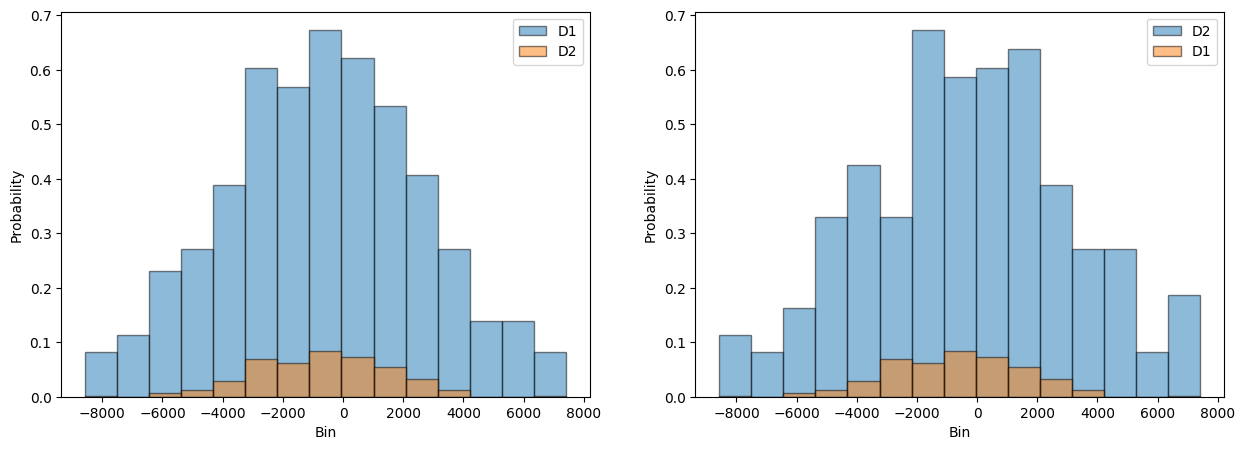

Testing:  01_1
Mean signed deviation ratio to actual:  0.8228949320652218
p-Value of 1 sample t-test:  0.18440022595864541
DP Predicate Test Result:  True


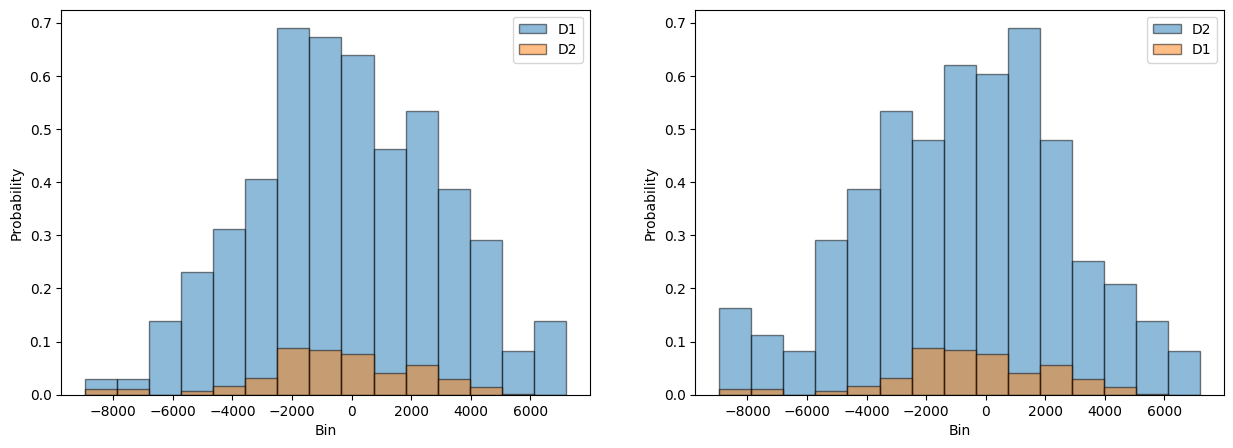

Test case:  [500.0, -777.7777777777778, 200.0]
Testing:  012_0
Mean signed deviation ratio to actual:  -0.07755900387001212
p-Value of 1 sample t-test:  0.8466355331971684
DP Predicate Test Result:  True


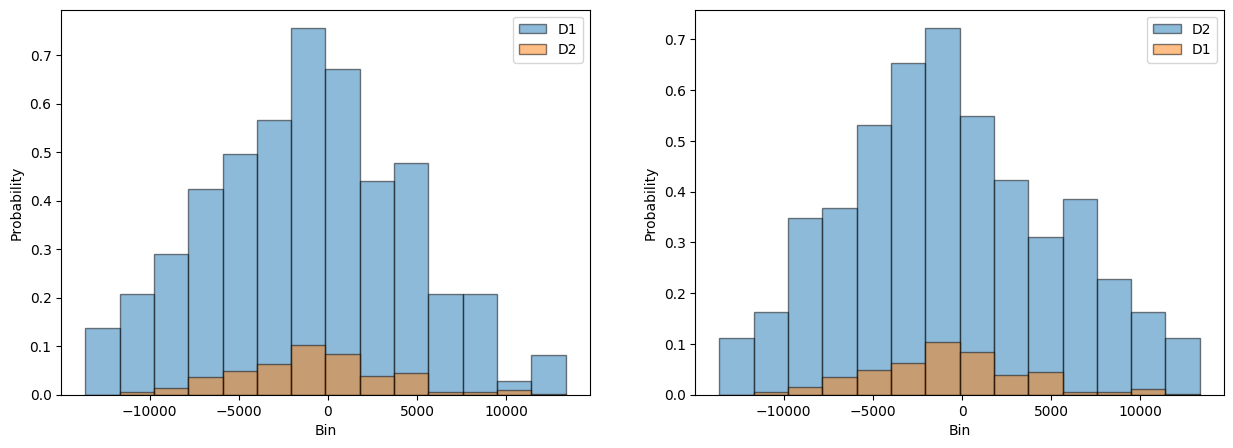

Testing:  12_1
Mean signed deviation ratio to actual:  0.23748375533621402
p-Value of 1 sample t-test:  0.49338038065652834
DP Predicate Test Result:  True


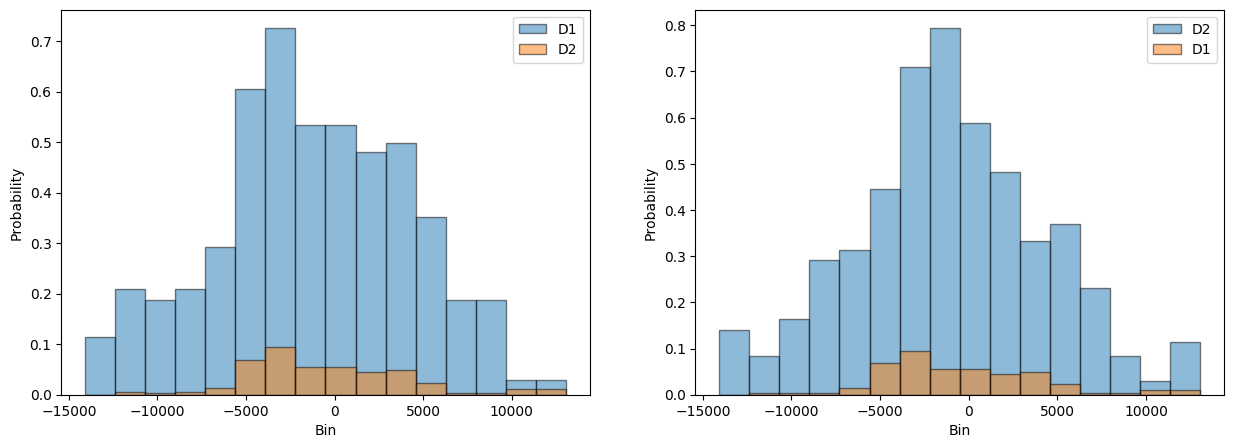

Testing:  2_2
Mean signed deviation ratio to actual:  -1.6998076305898504
p-Value of 1 sample t-test:  0.003344420937332913
DP Predicate Test Result:  True


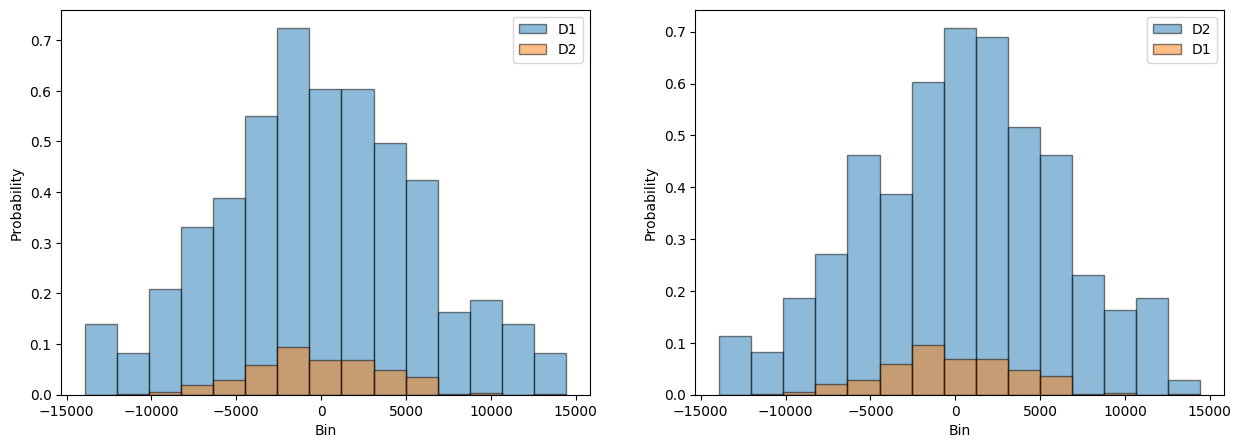

Testing:  12_2
Mean signed deviation ratio to actual:  -0.00238742900106524
p-Value of 1 sample t-test:  0.9946980083648684
DP Predicate Test Result:  True


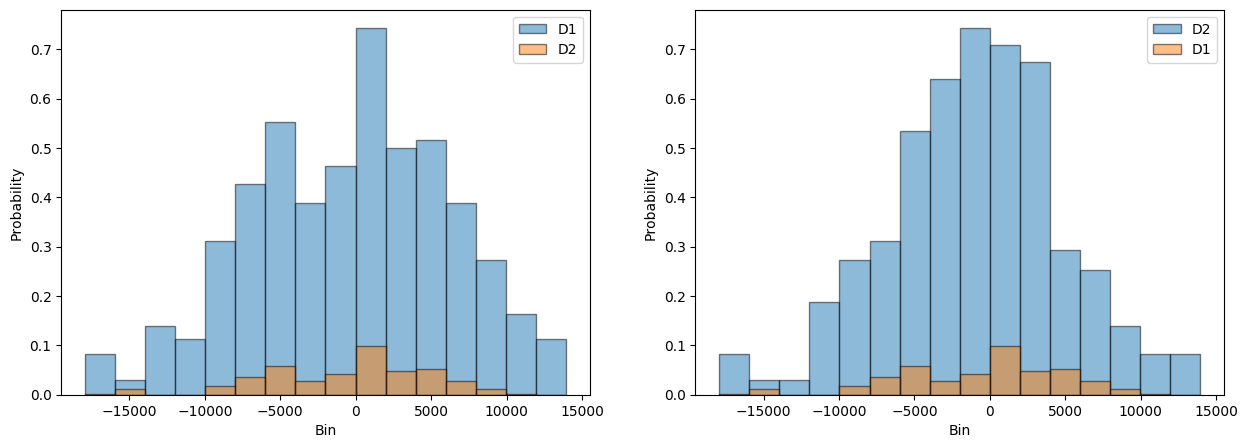

Testing:  1_1
Mean signed deviation ratio to actual:  -0.6338311826187564
p-Value of 1 sample t-test:  0.29410818036454744
DP Predicate Test Result:  True


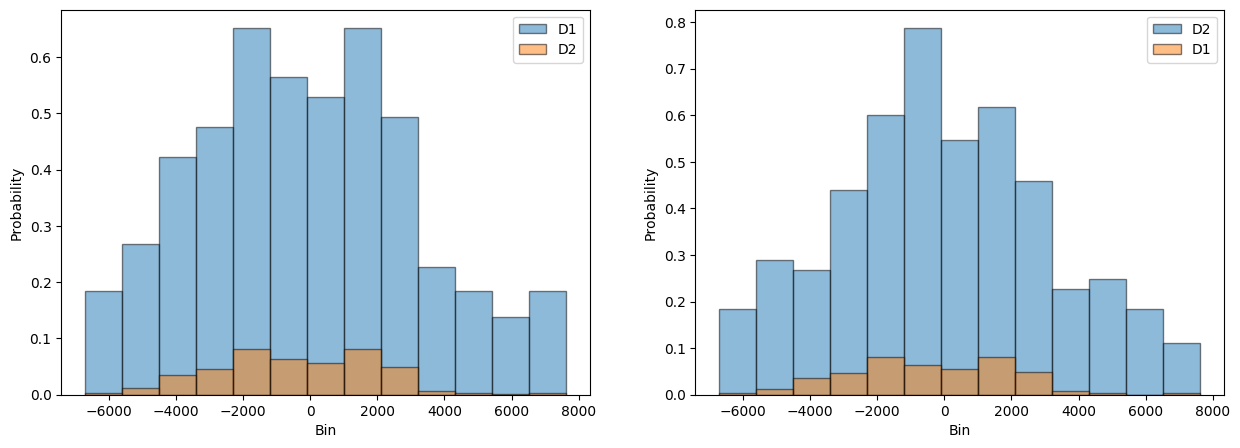

Testing:  012_1
Mean signed deviation ratio to actual:  -0.032478669938449944
p-Value of 1 sample t-test:  0.9305790061494627
DP Predicate Test Result:  True


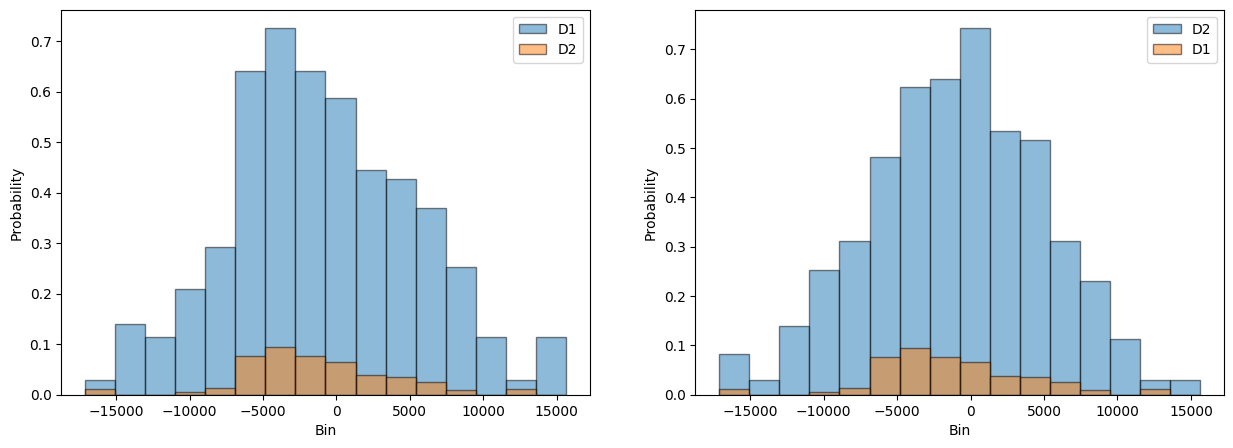

Testing:  02_0
Mean signed deviation ratio to actual:  0.08358673203317836
p-Value of 1 sample t-test:  0.8902534695394313
DP Predicate Test Result:  True


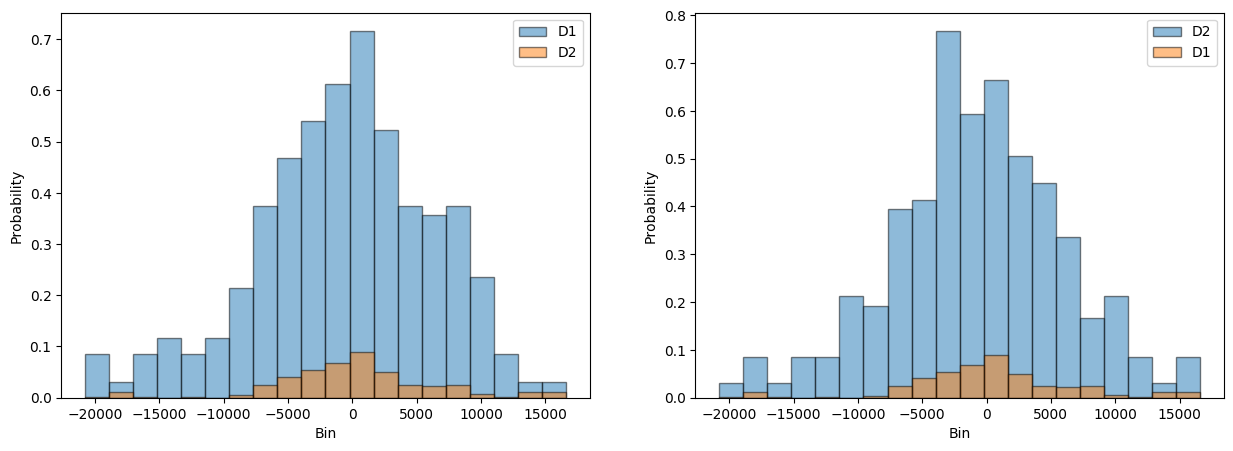

Testing:  02_2
Mean signed deviation ratio to actual:  0.07905328467925801
p-Value of 1 sample t-test:  0.9015473843590105
DP Predicate Test Result:  True


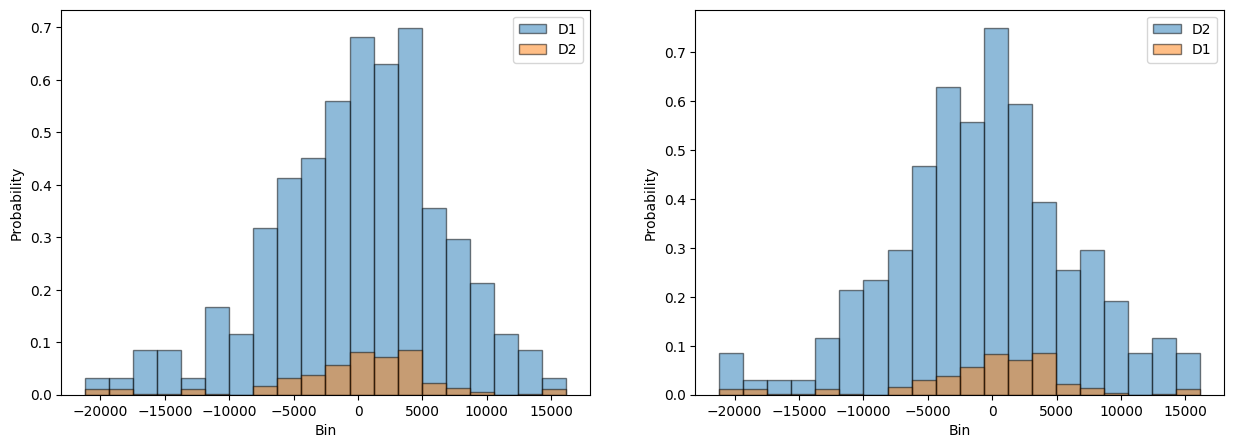

Testing:  0_0
Mean signed deviation ratio to actual:  nan
p-Value of 1 sample t-test:  nan
DP Predicate Test Result:  True


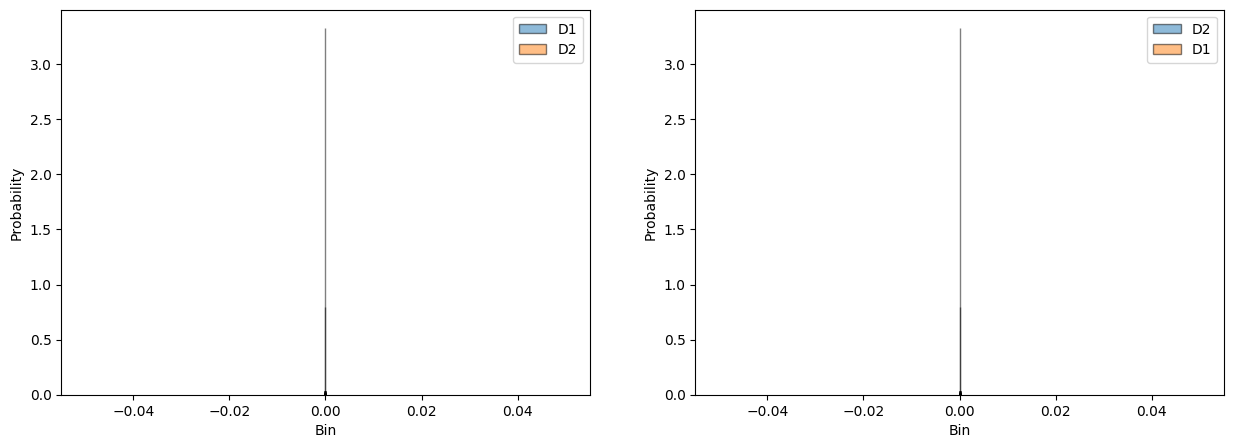

Testing:  012_2
Mean signed deviation ratio to actual:  -0.7082420039940324
p-Value of 1 sample t-test:  0.07542430330579619
DP Predicate Test Result:  True


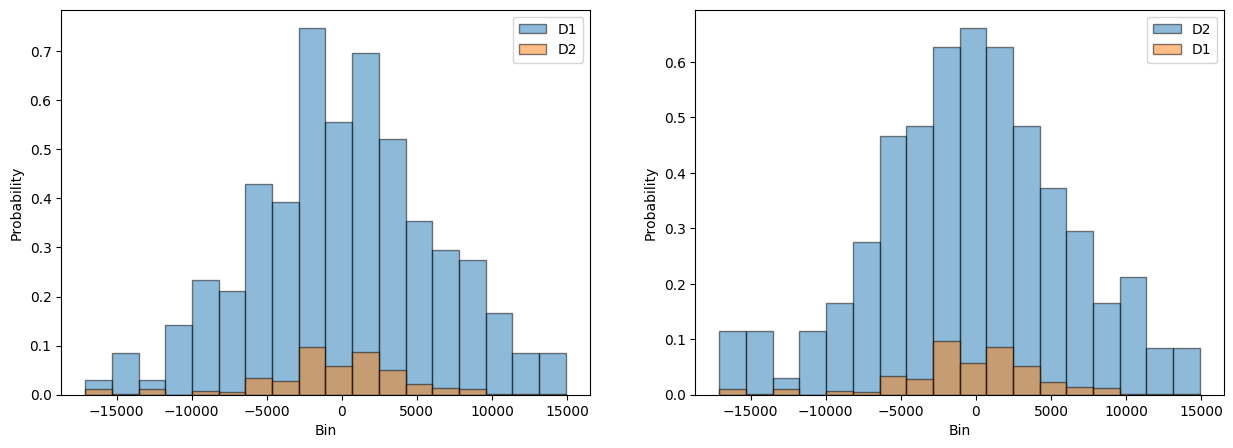

Testing:  01_0
Mean signed deviation ratio to actual:  -0.348026516257253
p-Value of 1 sample t-test:  0.5813219904264144
DP Predicate Test Result:  True


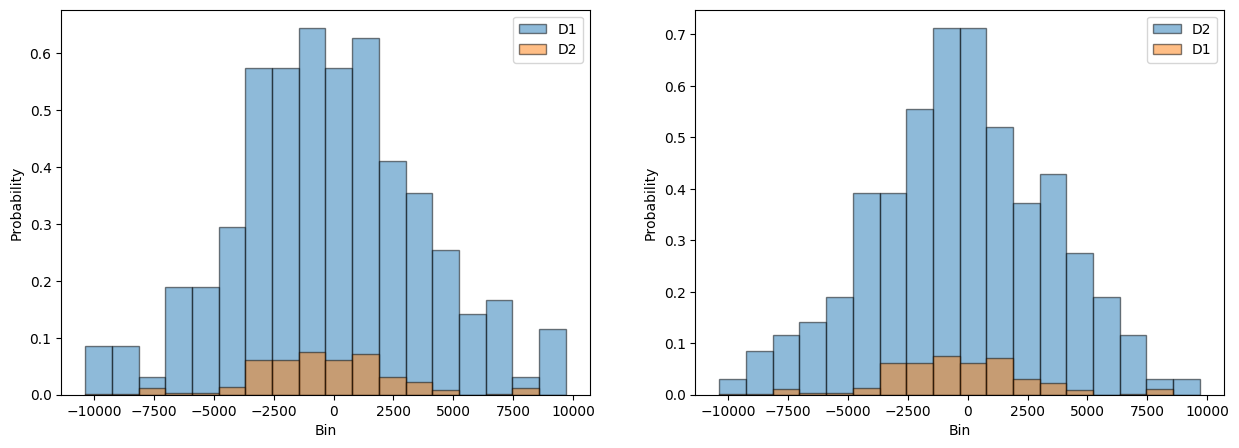

Testing:  01_1
Mean signed deviation ratio to actual:  -0.4414371658294691
p-Value of 1 sample t-test:  0.43058670315070213
DP Predicate Test Result:  True


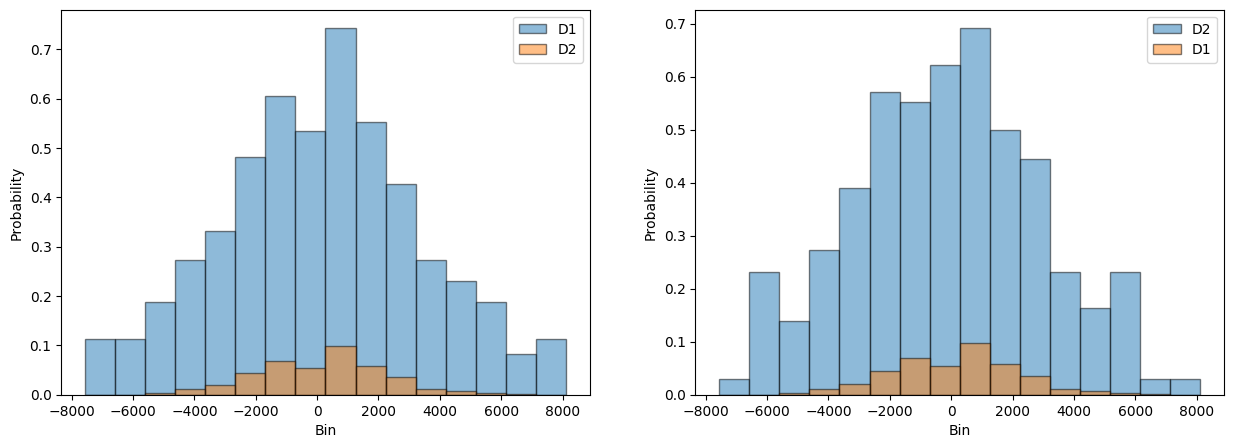

Test case:  [-750.0, -111.1111111111112, 600.0]
Testing:  012_0
Mean signed deviation ratio to actual:  -0.12479114004805243
p-Value of 1 sample t-test:  0.7474899819128246
DP Predicate Test Result:  True


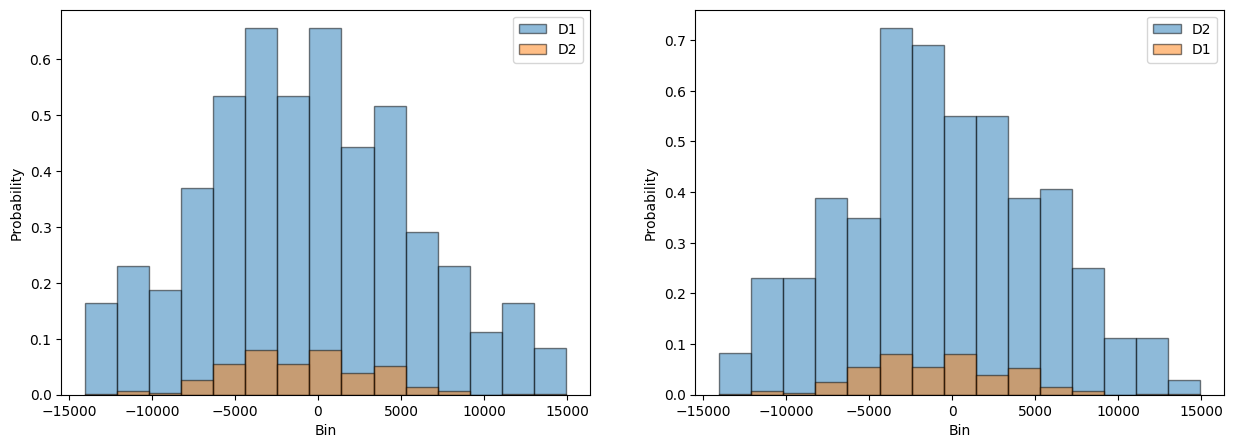

Testing:  12_1
Mean signed deviation ratio to actual:  0.1725653372691791
p-Value of 1 sample t-test:  0.6669560334401208
DP Predicate Test Result:  True


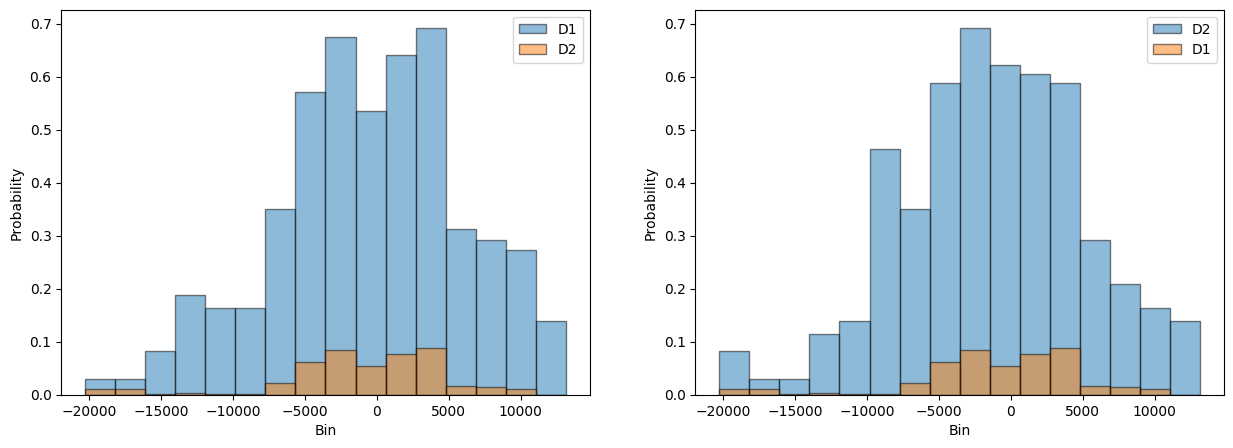

Testing:  2_2
Mean signed deviation ratio to actual:  -0.9636660107118856
p-Value of 1 sample t-test:  0.08801627476333153
DP Predicate Test Result:  True


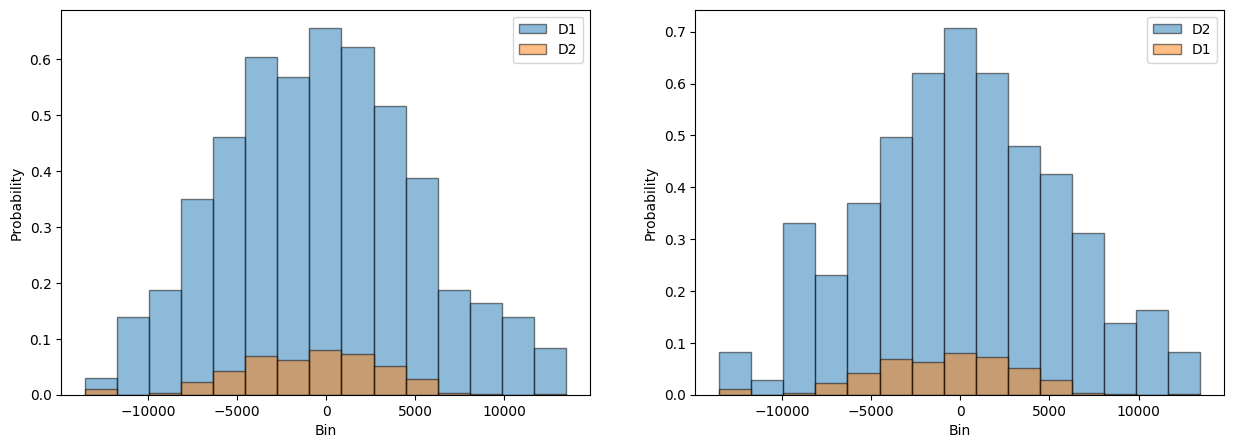

Testing:  12_2
Mean signed deviation ratio to actual:  0.2008452571682304
p-Value of 1 sample t-test:  0.6071876408530095
DP Predicate Test Result:  True


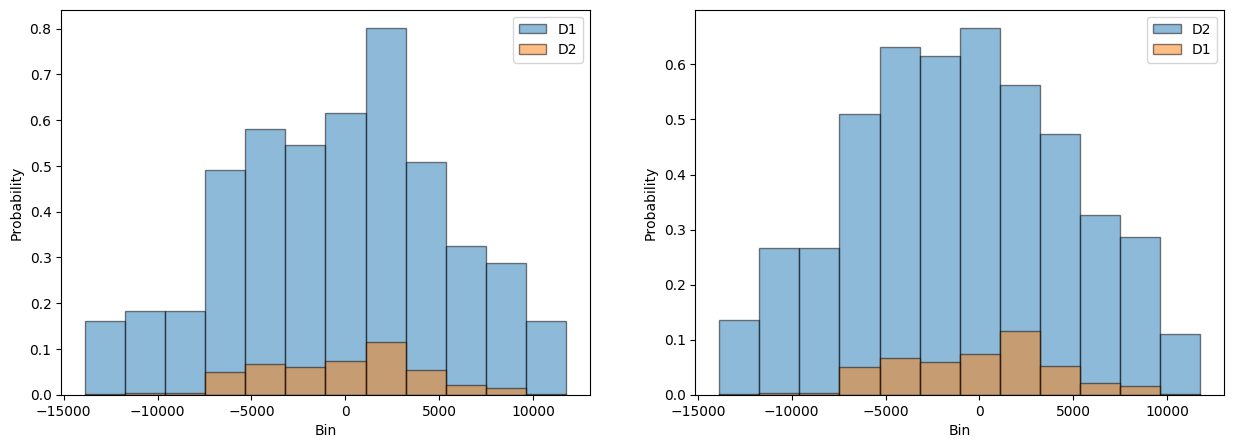

Testing:  1_1
Mean signed deviation ratio to actual:  -1.2111343251528255
p-Value of 1 sample t-test:  0.037271902196369854
DP Predicate Test Result:  True


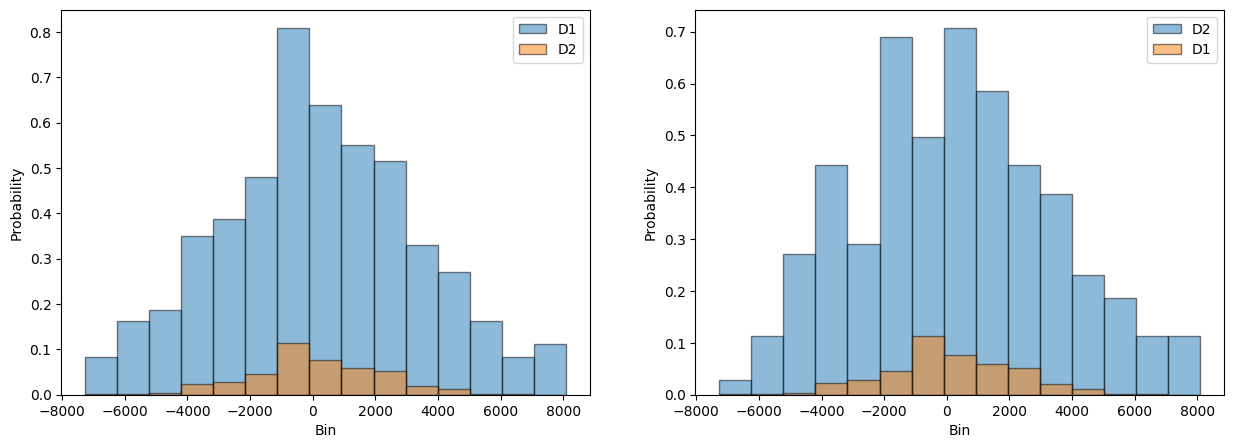

Testing:  012_1
Mean signed deviation ratio to actual:  0.2540001904695022
p-Value of 1 sample t-test:  0.4961341513663523
DP Predicate Test Result:  True


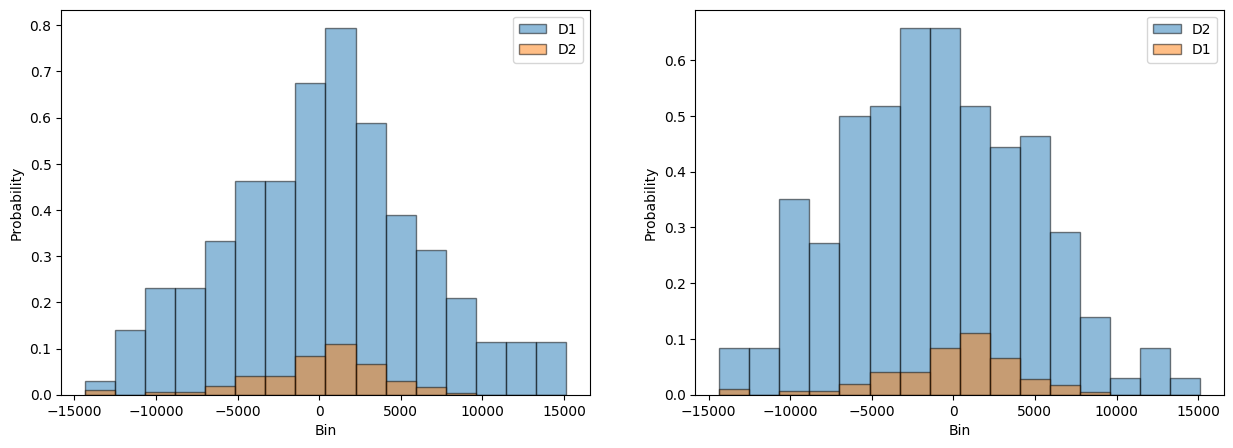

Testing:  02_0
Mean signed deviation ratio to actual:  -0.7937964284167733
p-Value of 1 sample t-test:  0.18267509115705924
DP Predicate Test Result:  True


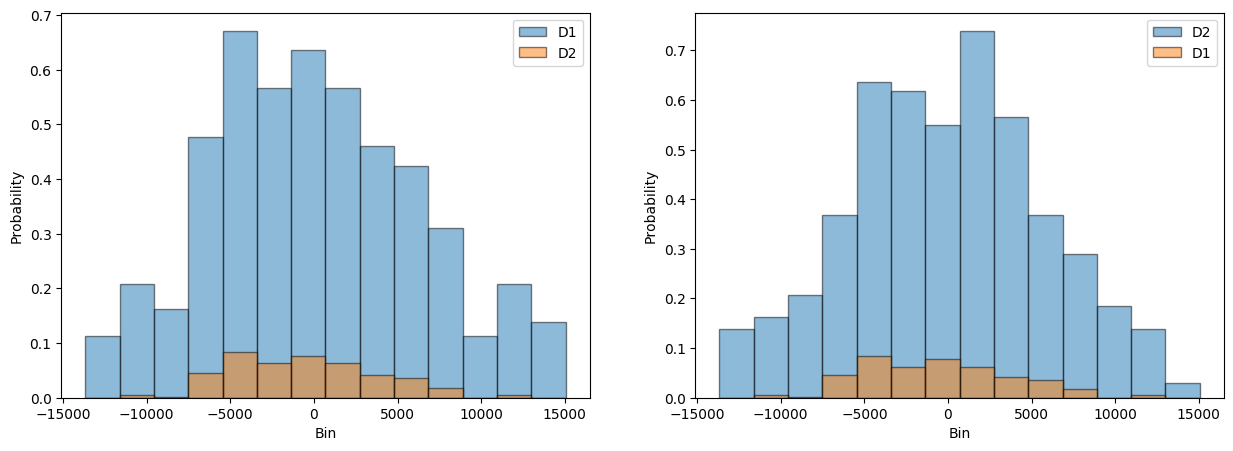

Testing:  02_2
Mean signed deviation ratio to actual:  -0.09226940197034844
p-Value of 1 sample t-test:  0.8732103679098868
DP Predicate Test Result:  True


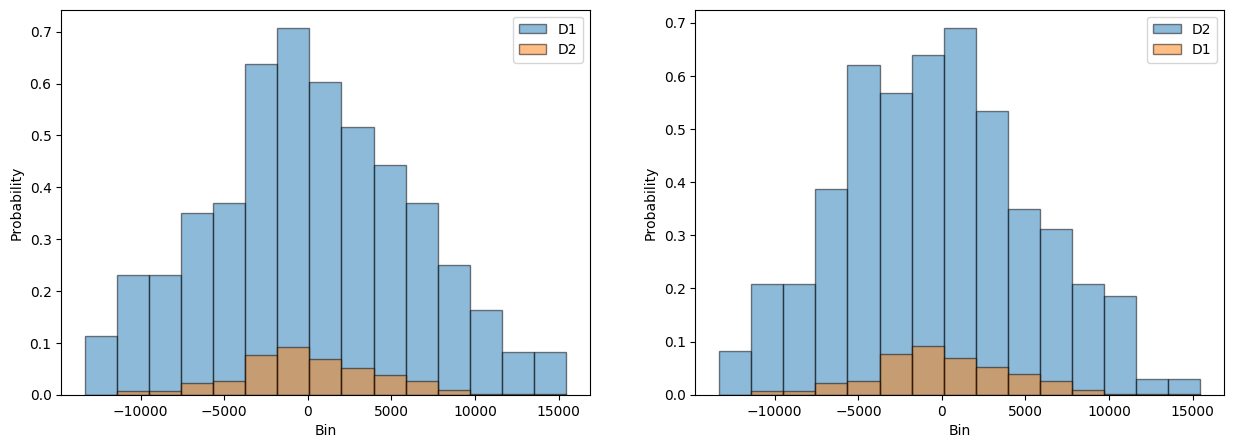

Testing:  0_0
Mean signed deviation ratio to actual:  nan
p-Value of 1 sample t-test:  nan
DP Predicate Test Result:  True


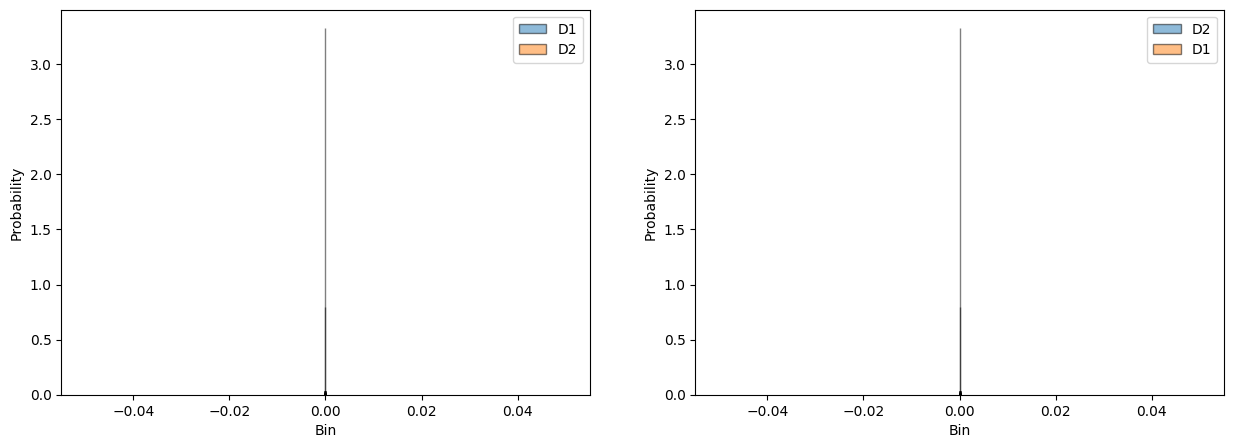

Testing:  012_2
Mean signed deviation ratio to actual:  -0.17169154488903032
p-Value of 1 sample t-test:  0.6384403812003179
DP Predicate Test Result:  True


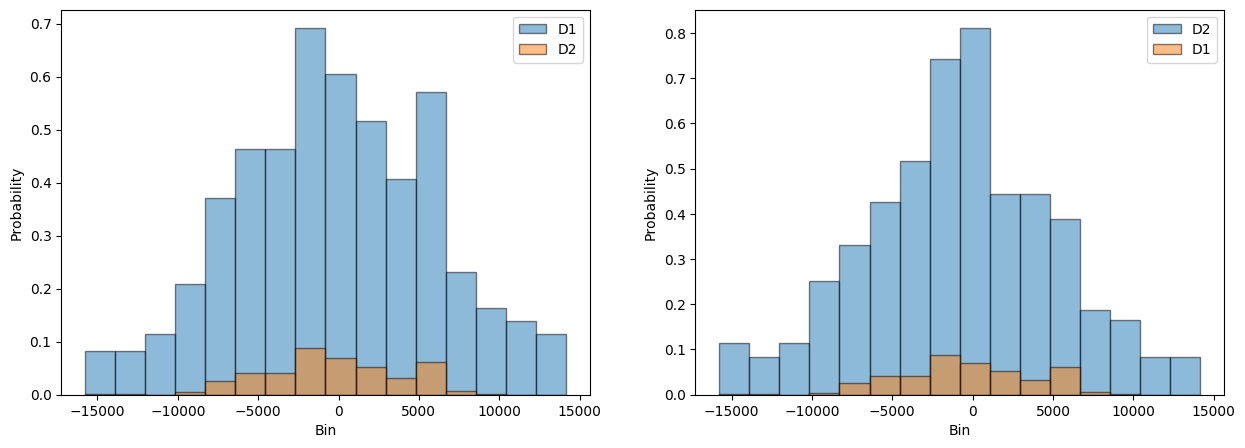

Testing:  01_0
Mean signed deviation ratio to actual:  -0.46488168945982056
p-Value of 1 sample t-test:  0.43993221820066286
DP Predicate Test Result:  True


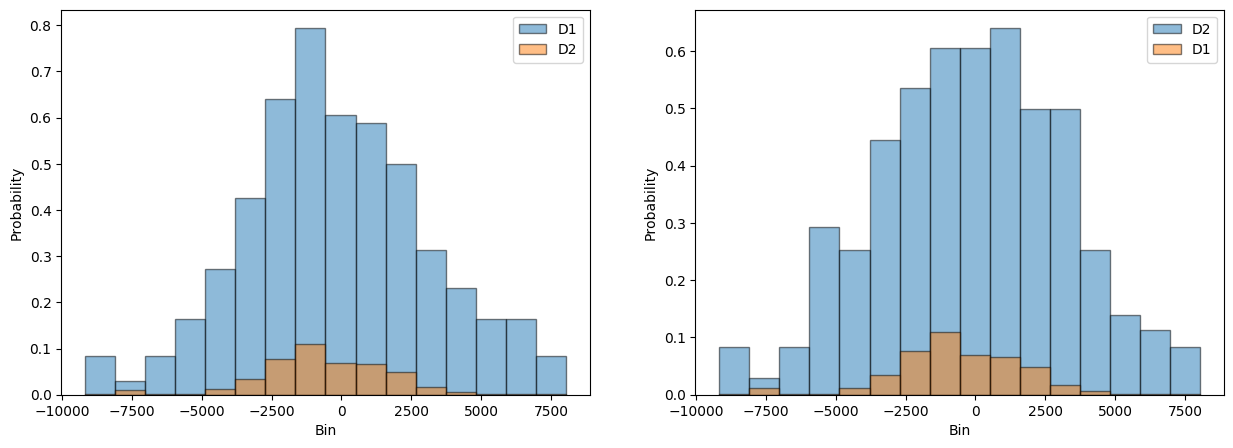

Testing:  01_1
Mean signed deviation ratio to actual:  0.2978345122362429
p-Value of 1 sample t-test:  0.6311648577565929
DP Predicate Test Result:  True


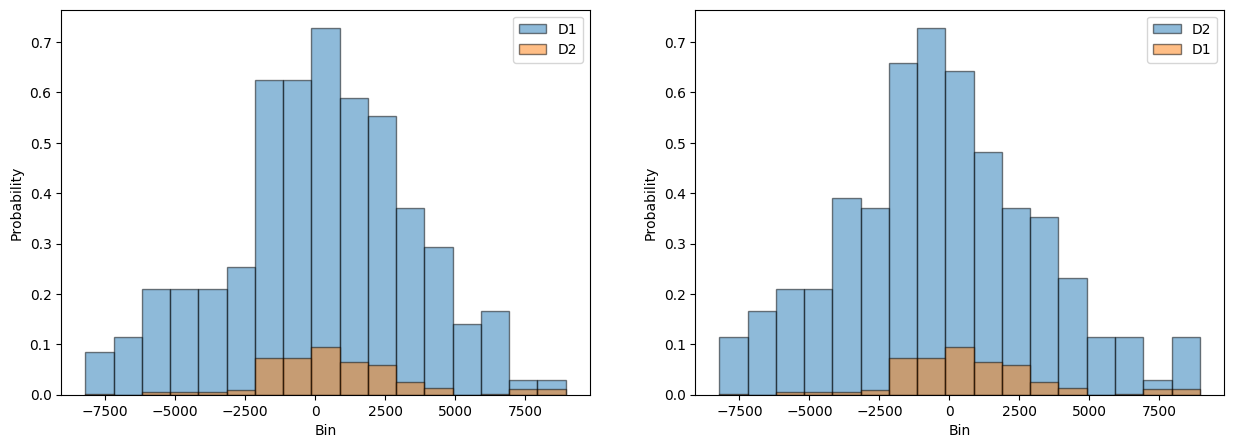

Test case:  [250.0, 555.5555555555554, -920.0]
Testing:  012_0
Mean signed deviation ratio to actual:  0.11992056328109621
p-Value of 1 sample t-test:  0.7530684116352488
DP Predicate Test Result:  True


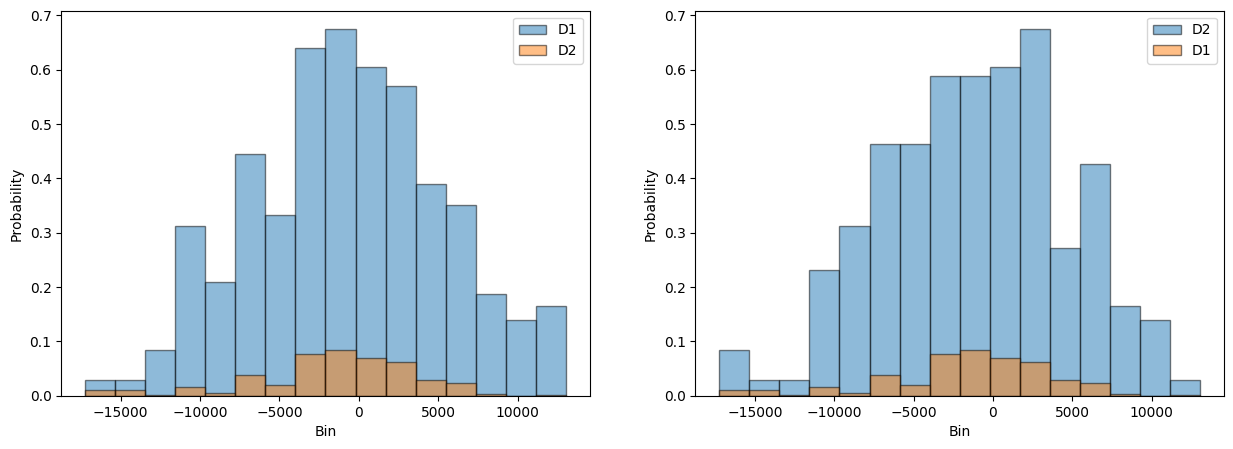

Testing:  12_1
Mean signed deviation ratio to actual:  -0.3212799152625163
p-Value of 1 sample t-test:  0.36440357658354294
DP Predicate Test Result:  True


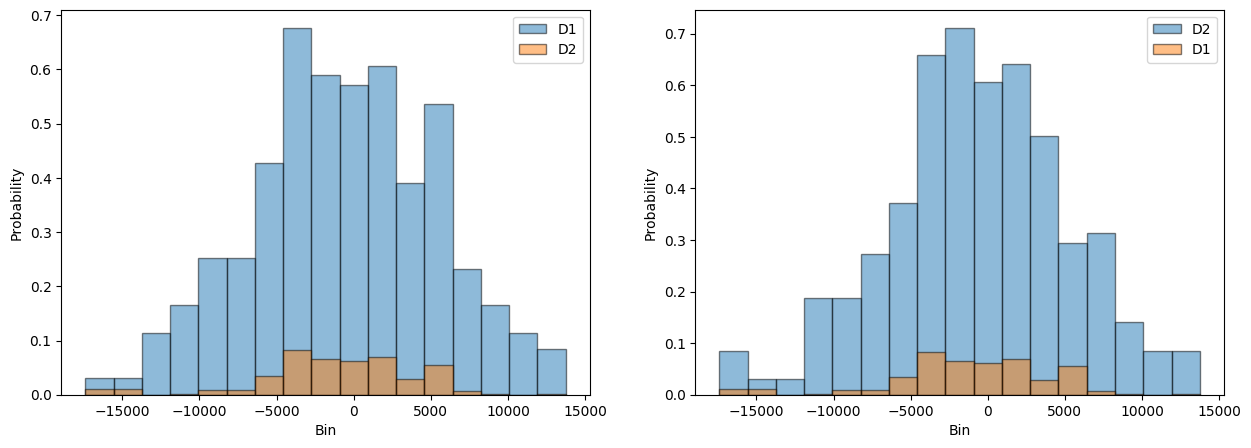

Testing:  2_2
Mean signed deviation ratio to actual:  -0.5419497537615773
p-Value of 1 sample t-test:  0.3685572580397979
DP Predicate Test Result:  True


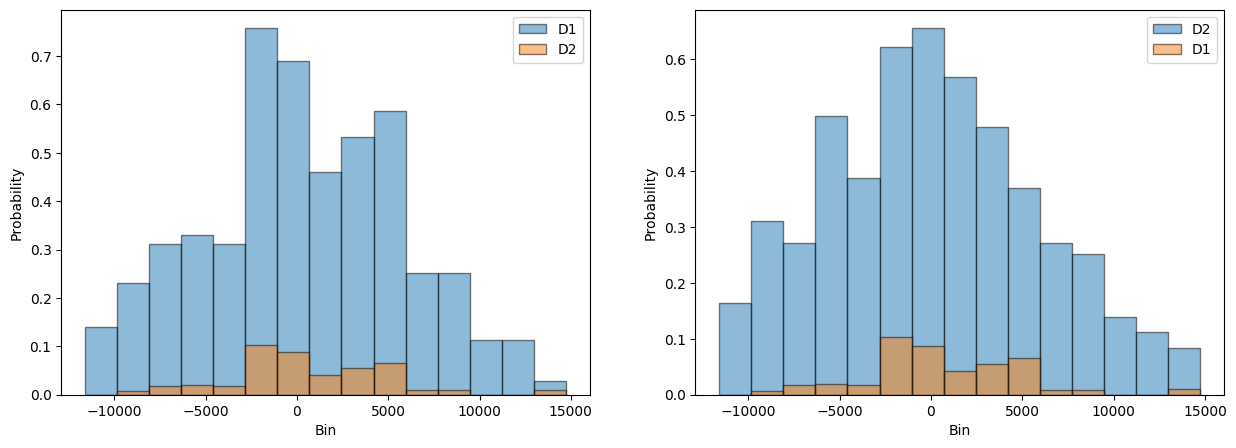

Testing:  12_2
Mean signed deviation ratio to actual:  0.042295274377670715
p-Value of 1 sample t-test:  0.9143553780502138
DP Predicate Test Result:  True


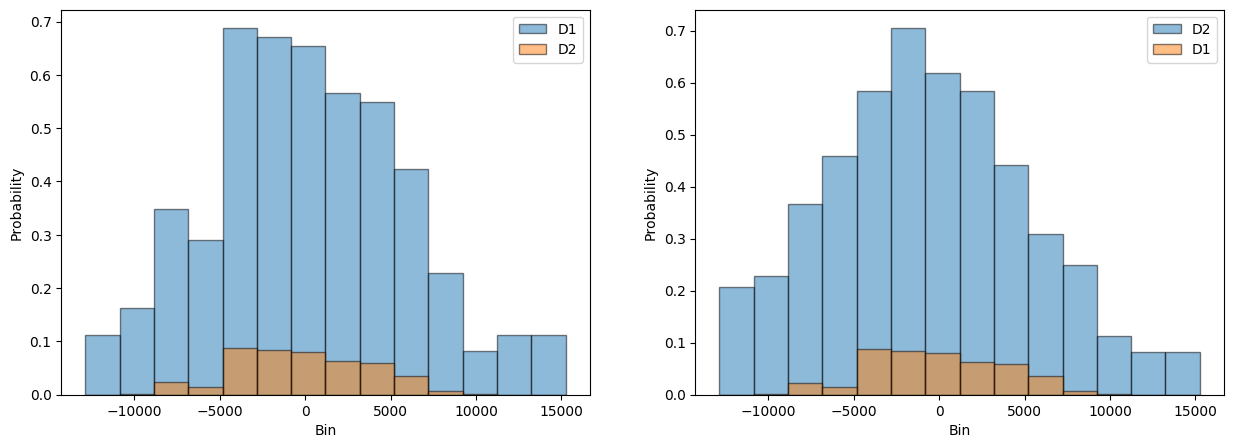

Testing:  1_1
Mean signed deviation ratio to actual:  -1.056616418261436
p-Value of 1 sample t-test:  0.07995118291325398
DP Predicate Test Result:  True


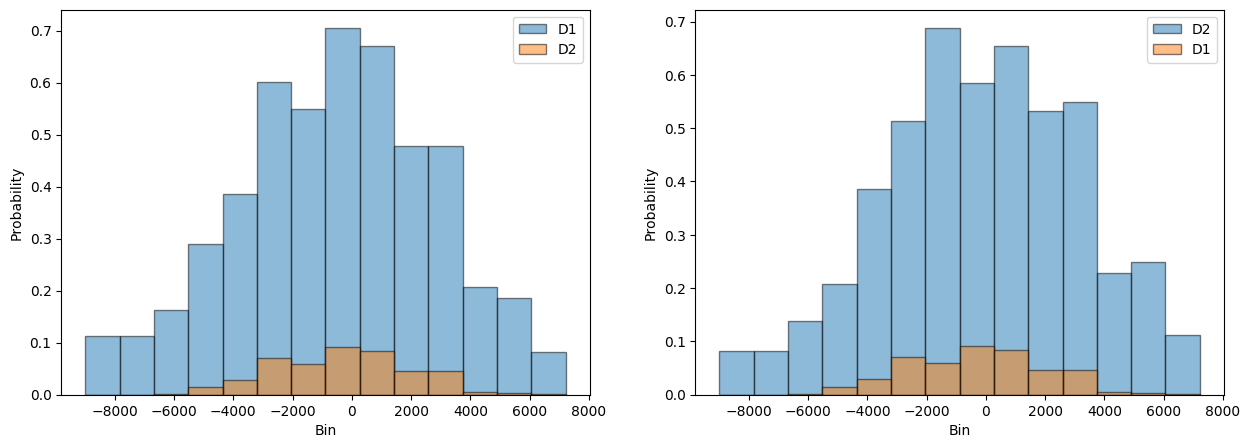

Testing:  012_1
Mean signed deviation ratio to actual:  -0.6151401370707823
p-Value of 1 sample t-test:  0.10833430293833553
DP Predicate Test Result:  True


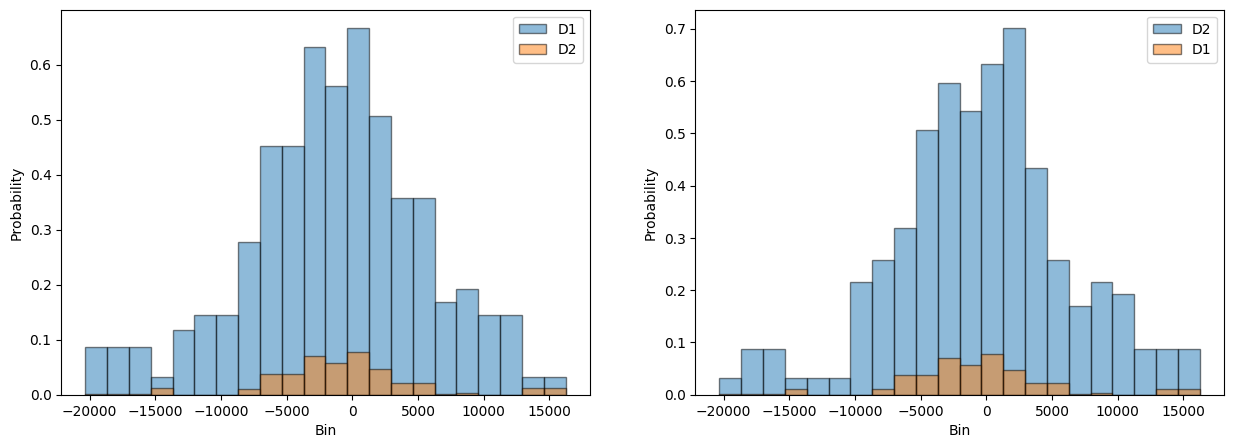

Testing:  02_0
Mean signed deviation ratio to actual:  0.2128010304739552
p-Value of 1 sample t-test:  0.6998178568115132
DP Predicate Test Result:  True


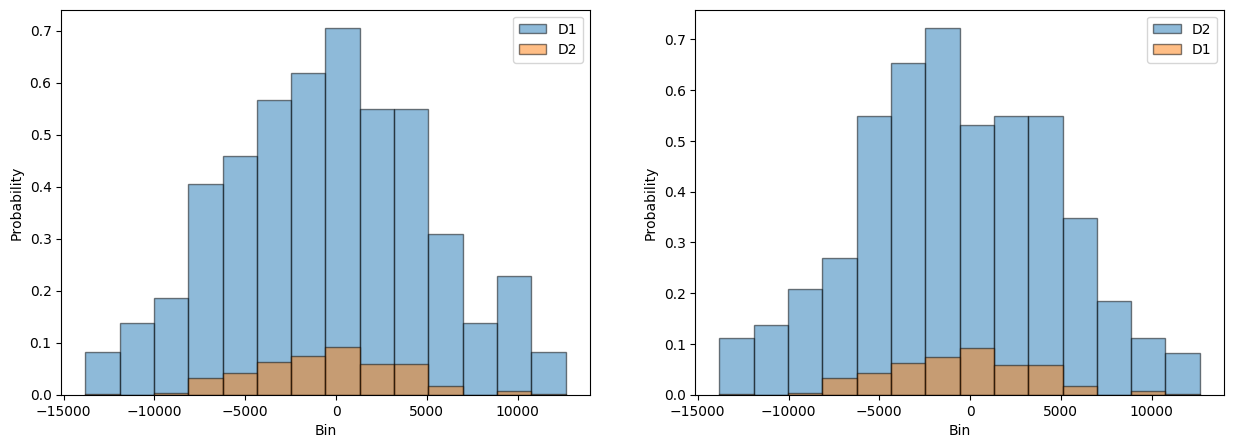

Testing:  02_2
Mean signed deviation ratio to actual:  -0.5495504001137772
p-Value of 1 sample t-test:  0.40801063102547475
DP Predicate Test Result:  True


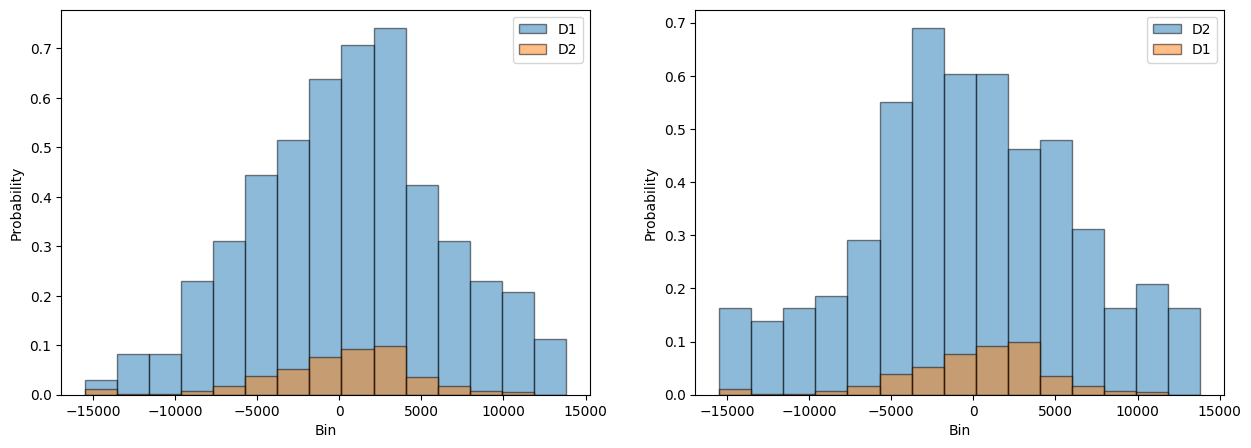

Testing:  0_0
Mean signed deviation ratio to actual:  nan
p-Value of 1 sample t-test:  nan
DP Predicate Test Result:  True


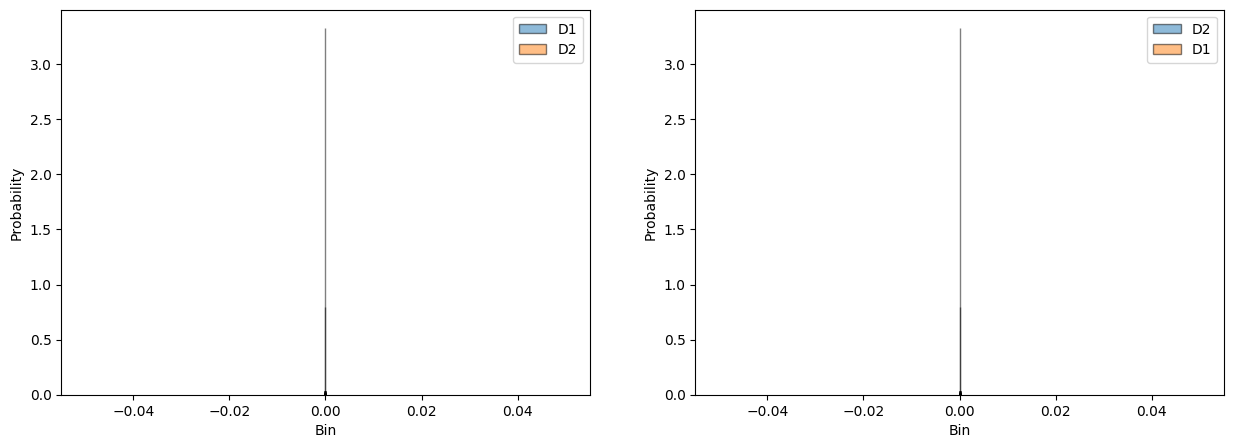

Testing:  012_2
Mean signed deviation ratio to actual:  0.013910054796511355
p-Value of 1 sample t-test:  0.9712769015447282
DP Predicate Test Result:  True


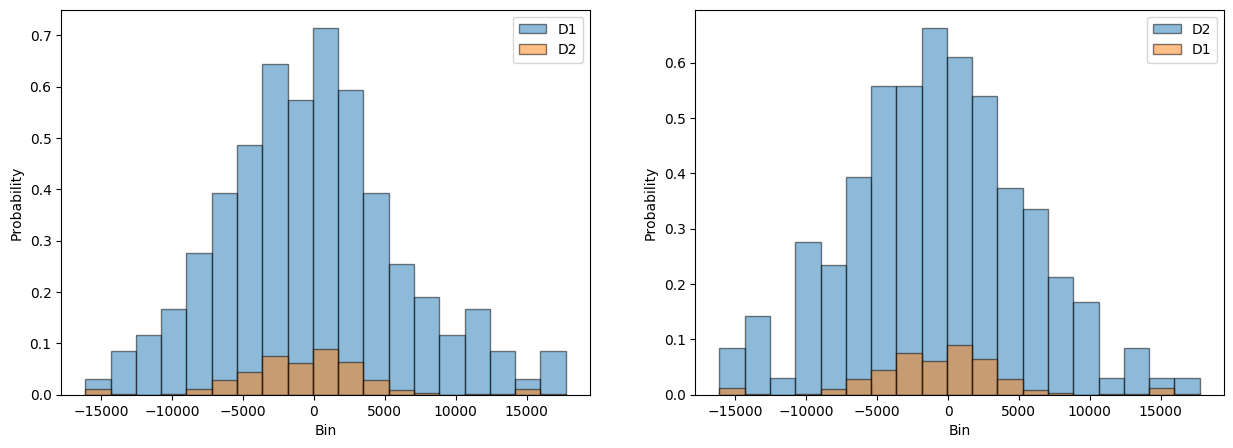

Testing:  01_0
Mean signed deviation ratio to actual:  -0.13032355116986793
p-Value of 1 sample t-test:  0.826237617588043
DP Predicate Test Result:  True


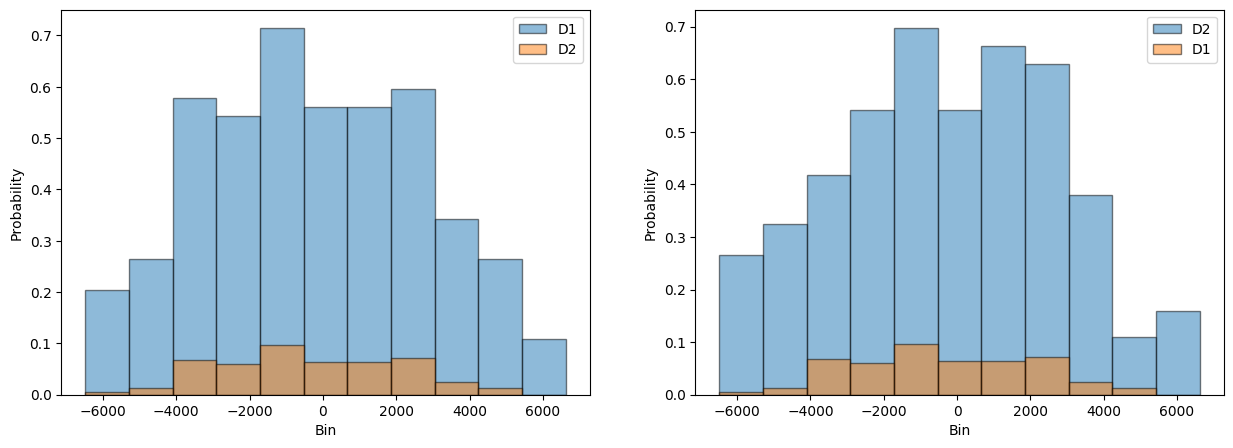

Testing:  01_1
Mean signed deviation ratio to actual:  0.07529479736332556
p-Value of 1 sample t-test:  0.8866367384625813
DP Predicate Test Result:  True


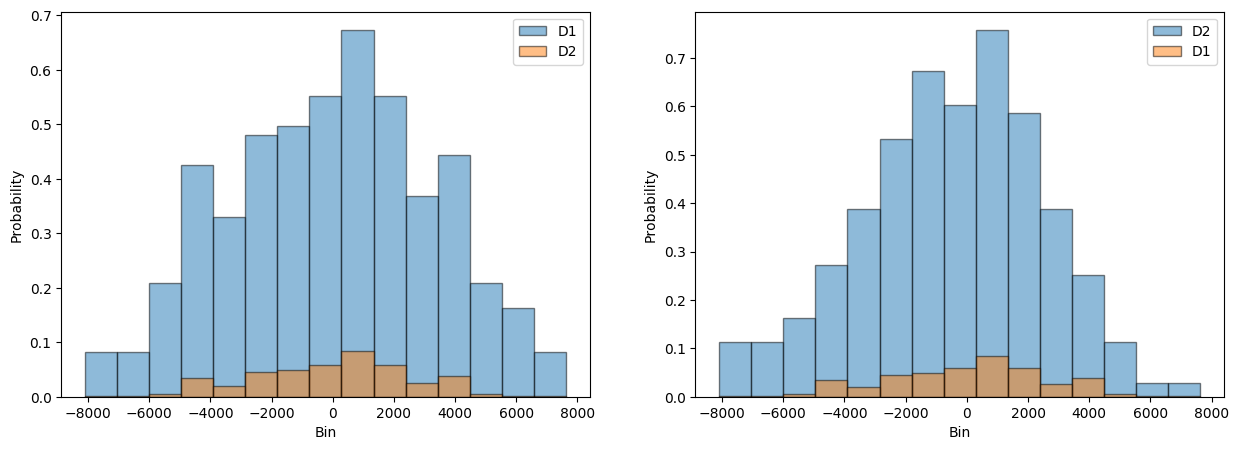

Halton sequence based Powerset Test Result
[0.0,-333.33333333333337,-600.0] - 012_0 - [True, None, None, None, True, 0.3248424467263661]
[0.0,-333.33333333333337,-600.0] - 12_1 - [True, None, None, None, False, -0.8270524612473353]
[0.0,-333.33333333333337,-600.0] - 2_2 - [True, None, None, None, False, -1.2862842175954239]
[0.0,-333.33333333333337,-600.0] - 12_2 - [True, None, None, None, True, -0.4440021023327993]
[0.0,-333.33333333333337,-600.0] - 1_1 - [True, None, None, None, True, -1.1421142694601338]
[0.0,-333.33333333333337,-600.0] - 012_1 - [True, None, None, None, True, -0.16220149940321107]
[0.0,-333.33333333333337,-600.0] - 02_0 - [True, None, None, None, True, 0.21262762769616061]
[0.0,-333.33333333333337,-600.0] - 02_2 - [True, None, None, None, False, -1.3469954654379932]
[0.0,-333.33333333333337,-600.0] - 0_0 - [True, None, None, None, False, nan]
[0.0,-333.33333333333337,-600.0] - 012_2 - [True, None, None, None, True, 0.29540355087739634]
[0.0,-333.33333333333337,-600

In [24]:
start_time = time.time()
query_str = "SELECT SUM(Usage) AS TotalUsage FROM "
dp_res, acc_res, utility_res, bias_res = dv.dp_powerset_test(query_str, repeat_count=200, plot=True)
print("DP Predicate Test: ", dp_res)
#print("Accuracy Test: ", acc_res)
#print("Utility Test: ", utility_res)
print("Bias Test: ", bias_res)
print("--- %s seconds ---" % (time.time() - start_time))